In [ ]:
import tensorflow as tf

import nobrainer
from nobrainer import dataset, volume

from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()

dir_path = os.path.abspath("csv/faced_defaced/train_test_fold_1/csv/")
csv_path = os.path.join(dir_path, "training.csv")
# print(dir_path, csv_path)


labels = pd.read_csv(csv_path)["Y"].values
paths = pd.read_csv(csv_path)["X"].values


# print(labels)

n_classes=2
volume_shape = (256, 256, 256)
block_shape = (128, 128, 128)


training_paths = zip(paths, labels)

print(training_paths)

In [2]:
import matplotlib 
# matplotlib.use('Agg')
import os, sys
sys.path.append('../defacing')

from preprocessing.normalization import clip, standardize, normalize
from preprocessing.conform import conform_data
from helpers.utils import load_vol, save_vol, is_gz_file
import numpy as np
import nibabel as nib
from glob import glob
import matplotlib.pyplot as plt
import tempfile

In [9]:
import matplotlib 
# matplotlib.use('Agg')
import os, sys
sys.path.append('../defacing')

from preprocessing.normalization import clip, standardize, normalize
from preprocessing.conform import conform_data
from helpers.utils import load_vol, save_vol, is_gz_file
import numpy as np
import nibabel as nib
from glob import glob
import matplotlib.pyplot as plt
import tempfile


orig_root_dir = '/work/01329/poldrack/data/mriqc-net/data'
orig_data_face = os.path.join(orig_root_dir, 'face/T1w')
orig_data_mask = os.path.join(orig_root_dir, 'masks')

save_root_dir = '/work/06850/sbansal6/maverick2/mriqc-shared/'

save_preprocessing_face = os.path.join(save_root_dir, 'preprocessing/face')
save_conformed_face = os.path.join(save_root_dir, 'conformed/face')

save_preprocessing_deface = os.path.join(save_root_dir, 'preprocessing/deface')
save_conformed_deface = os.path.join(save_root_dir, 'conformed/deface')

os.makedirs(save_preprocessing_face, exist_ok=True)
os.makedirs(save_preprocessing_deface, exist_ok=True)
os.makedirs(save_conformed_face, exist_ok=True)
os.makedirs(save_conformed_deface, exist_ok=True)

conform_size = (64, 64, 64)
conform_zoom = (4., 4., 4.)


def preprocess(orig_vol_pth, conform_pth, preprocess_pth, DS=None, mask_path=None, debug=False):
    """
    """
    
    filename = orig_vol_pth.split('/')[-1]
    volume, affine, _ = load_vol(orig_vol_pth)
    
    # Preprocessing
    volume = clip(volume, q=90)
    volume = normalize(volume)
    volume = standardize(volume)
    
    # 
    save_preprocessing_path = os.path.join(preprocess_pth, filename)
    save_conformed_path = os.path.join(conform_pth, filename)
    
    print("save_preprocessing_path: ", save_preprocessing_path)
    print("save_conformed_path: ", save_conformed_path)
    
    save_vol(save_preprocessing_path, volume, affine)

    def _plot(data):
        f, axarr = plt.subplots(8, 8, figsize=(12, 12))
        for i in range(8):
            for j in range(8):
                axarr[i, j].imshow(np.rot90(data[:, :, j + 8*i], 1))

        plt.show()
        
#         """
#         plt.subplot(1, 3, 1)
#         plt.imshow(np.rot90(np.mean(data, axis=0)))
#         plt.subplot(1, 3, 2)
#         plt.imshow(np.rot90(np.mean(data, axis=1)))
#         plt.subplot(1, 3, 3)
#         plt.imshow(np.rot90(np.mean(data, axis=2)))
#         plt.show()
#         """
    conform_data(save_preprocessing_path, 
                 out_file=save_conformed_path, 
                 out_size=conform_size, 
                 out_zooms=conform_zoom)

#     if debug: _plot(load_vol(save_conformed_path)[0])
    
    if mask_path and DS:
        mask = np.array(nib.load(mask_path).dataobj)
        masked_volume = volume*mask

        save_mpreprocessing_path = os.path.join(save_preprocessing_deface, DS, filename)
        save_mconformed_path = os.path.join(save_conformed_deface, DS, filename)
        
        print("save_deface_preprocessing_path: ", save_mpreprocessing_path)
        print("save_deface_conformed_path: ", save_mconformed_path)
        
#         os.makedirs(save_mpreprocessing_path, exist_ok=True)
        os.makedirs(os.path.dirname(save_mconformed_path), exist_ok=True)
    
#         save_mpreprocessing_path = os
        
        save_vol(save_mpreprocessing_path, masked_volume, affine)

        conform_data(save_mpreprocessing_path, 
                 out_file=save_mconformed_path, 
                 out_size=conform_size, 
                 out_zooms=conform_zoom)        
        
        return save_conformed_path, save_mconformed_path

    return save_conformed_path


def checkNonConformed(orig_path, save_path):

    conform = []
    orig = []

    for path in glob(save_path + "/*/*.nii*"):
        tempname = path.split("/")[-1]
        ds = path.split("/")[-2]
        conform.append(ds + "/" + tempname)

    print("Total Conformed: ", len(conform))

    for path in glob(orig_path + "/*/*.nii*"):
        tempname = path.split("/")[-1]
        ds = path.split("/")[-2]
        orig.append(ds + "/" + tempname)

    print("Total Original: ", len(orig))

    print("Total not conformed: ", len(orig) - len(conform))

    count = 0
    for f in orig:
        exists = False
        for fc in conform:
            if fc in f:
                exists = True
        if not exists:
            count += 1
            print("Not conformed file: ", f)


for path in glob(orig_data_face + "/*/*.nii*"):
    try:
        if 'ds000140_anat' not in path:
            print("Orig Path: ", path)
            # Example: 
            #        vol_name - sub-22_T1w.nii.gz
            #        DS - ds000140_anat
            vol_name = path.split("/")[-1]
            DS = path.split("/")[-2]
            
            
                
            # directories for saving preprocessed and conformed volumes
            ds_save_conform_path = os.path.join(save_conformed_face, DS)
            ds_save_preprocess_path = os.path.join(save_preprocessing_face, DS)

            # Get the mask path
            mask_path = glob(os.path.join(orig_data_mask, DS, vol_name.split('.')[0] + "*_mask*"))[0]

            print("Mask_path", mask_path)

            if not os.path.exists(ds_save_conform_path):
                os.makedirs(ds_save_conform_path)

            if not os.path.exists(ds_save_preprocess_path):
                os.makedirs(ds_save_preprocess_path)

            # Check if volume is a proper gunzipped
            if not os.path.splitext(path)[1] == ".gz" and is_gz_file(path):
                rename_file = os.path.splitext(vol_name)[0]
                fixed_gz_tmp = os.path.join(save_conformed_face, rename_file)
                print(fixed_gz_tmp)
                subprocess.call(["cp", path, fixed_gz_tmp])

                print(preprocess(fixed_gz_tmp,
                                 ds_save_conform_path,
                                 ds_save_preprocess_path,
                                 mask_path = mask_path,
                                 DS=DS
                                ))
                os.remove(fixed_gz_tmp)

            else:
                print(preprocess(path,
                                 ds_save_conform_path,
                                 ds_save_preprocess_path,
                                 mask_path = mask_path,
                                 DS=DS
                                ))
    except:
        print("Preprocessing incomplete. Exception occurred.")
        pass


# for path in glob(orig_data_deface + "/*/*.nii*"):
#     try:
#         print("Orig Path: ", path)
#         if not is_gz_file(path) and os.path.splitext(path)[1] == ".gz":
#             tempname = path.split("/")[-1]
#             ds = path.split("/")[-2]
#             rename_file = os.path.splitext(tempname)[0]
#             dst = os.path.join(save_data_deface, rename_file)
# #             print(dst)
#             subprocess.call(["cp", path, dst])
#             ds_save_path = os.path.join(save_data_deface, ds)
#             if not os.path.exists(ds_save_path):
#                 os.makedirs(ds_save_path)
#             preprocess(dst, conform_size, save_data_path=ds_save_path))
#         else:
#             ds = path.split("/")[-2]
#             ds_save_path = os.path.join(save_data_deface, ds)
#             if not os.path.exists(ds_save_path):
#                 os.makedirs(ds_save_path)
#             preprocess(path, conform_size, save_data_path=ds_save_path)
#     except:
#         print("Preprocessing incomplete. Exception occurred.")
#         pass
    

# checkNonConformed(orig_data_face, save_data_face)
# checkNonConformed(orig_data_deface, save_data_deface)


Orig Path:  /work/01329/poldrack/data/mriqc-net/data/face/T1w/ds000119_anat/sub-10_T1w.nii.gz
Mask_path /work/01329/poldrack/data/mriqc-net/data/masks/ds000119_anat/sub-10_T1w_pydeface_mask.nii.gz
save_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/face/ds000119_anat/sub-10_T1w.nii.gz
save_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds000119_anat/sub-10_T1w.nii.gz
save_deface_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/deface/ds000119_anat/sub-10_T1w.nii.gz
save_deface_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds000119_anat/sub-10_T1w.nii.gz
('/work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds000119_anat/sub-10_T1w.nii.gz', '/work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds000119_anat/sub-10_T1w.nii.gz')
Orig Path:  /work/01329/poldrack/data/mriqc-net/data/face/T1w/ds000119_anat/sub-07_T1w.nii.gz
Mask_path /work/01329/poldrack/d

save_deface_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/deface/ds000119_anat/sub-22_T1w.nii.gz
save_deface_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds000119_anat/sub-22_T1w.nii.gz
('/work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds000119_anat/sub-22_T1w.nii.gz', '/work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds000119_anat/sub-22_T1w.nii.gz')
Orig Path:  /work/01329/poldrack/data/mriqc-net/data/face/T1w/ds000119_anat/sub-52_T1w.nii.gz
Mask_path /work/01329/poldrack/data/mriqc-net/data/masks/ds000119_anat/sub-52_T1w_pydeface_mask.nii.gz
save_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/face/ds000119_anat/sub-52_T1w.nii.gz
save_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds000119_anat/sub-52_T1w.nii.gz
save_deface_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/deface/ds000119_anat/sub-52_T1w.nii

save_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/face/ds000119_anat/sub-69_T1w.nii.gz
save_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds000119_anat/sub-69_T1w.nii.gz
save_deface_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/deface/ds000119_anat/sub-69_T1w.nii.gz
save_deface_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds000119_anat/sub-69_T1w.nii.gz
('/work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds000119_anat/sub-69_T1w.nii.gz', '/work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds000119_anat/sub-69_T1w.nii.gz')
Orig Path:  /work/01329/poldrack/data/mriqc-net/data/face/T1w/ds000119_anat/sub-26_T1w.nii.gz
Mask_path /work/01329/poldrack/data/mriqc-net/data/masks/ds000119_anat/sub-26_T1w_pydeface_mask.nii.gz
save_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/face/ds000119_anat/sub-26_T1w.nii.gz
save_

('/work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds000119_anat/sub-24_T1w.nii.gz', '/work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds000119_anat/sub-24_T1w.nii.gz')
Orig Path:  /work/01329/poldrack/data/mriqc-net/data/face/T1w/ds000119_anat/sub-17_T1w.nii.gz
Mask_path /work/01329/poldrack/data/mriqc-net/data/masks/ds000119_anat/sub-17_T1w_pydeface_mask.nii.gz
save_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/face/ds000119_anat/sub-17_T1w.nii.gz
save_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds000119_anat/sub-17_T1w.nii.gz
save_deface_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/deface/ds000119_anat/sub-17_T1w.nii.gz
save_deface_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds000119_anat/sub-17_T1w.nii.gz
('/work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds000119_anat/sub-17_T1w.nii.gz', '/work/06850/sbansal6/maverick2

save_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/face/ds000119_anat/sub-63_T1w.nii.gz
save_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds000119_anat/sub-63_T1w.nii.gz
save_deface_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/deface/ds000119_anat/sub-63_T1w.nii.gz
save_deface_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds000119_anat/sub-63_T1w.nii.gz
('/work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds000119_anat/sub-63_T1w.nii.gz', '/work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds000119_anat/sub-63_T1w.nii.gz')
Orig Path:  /work/01329/poldrack/data/mriqc-net/data/face/T1w/ds000119_anat/sub-21_T1w.nii.gz
Mask_path /work/01329/poldrack/data/mriqc-net/data/masks/ds000119_anat/sub-21_T1w_pydeface_mask.nii.gz
save_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/face/ds000119_anat/sub-21_T1w.nii.gz
save_

('/work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds000119_anat/sub-42_T1w.nii.gz', '/work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds000119_anat/sub-42_T1w.nii.gz')
Orig Path:  /work/01329/poldrack/data/mriqc-net/data/face/T1w/ds000119_anat/sub-59_T1w.nii.gz
Mask_path /work/01329/poldrack/data/mriqc-net/data/masks/ds000119_anat/sub-59_T1w_pydeface_mask.nii.gz
save_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/face/ds000119_anat/sub-59_T1w.nii.gz
save_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds000119_anat/sub-59_T1w.nii.gz
save_deface_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/deface/ds000119_anat/sub-59_T1w.nii.gz
save_deface_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds000119_anat/sub-59_T1w.nii.gz
('/work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds000119_anat/sub-59_T1w.nii.gz', '/work/06850/sbansal6/maverick2

save_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/face/ds000119_anat/sub-14_T1w.nii.gz
save_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds000119_anat/sub-14_T1w.nii.gz
save_deface_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/deface/ds000119_anat/sub-14_T1w.nii.gz
save_deface_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds000119_anat/sub-14_T1w.nii.gz
('/work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds000119_anat/sub-14_T1w.nii.gz', '/work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds000119_anat/sub-14_T1w.nii.gz')
Orig Path:  /work/01329/poldrack/data/mriqc-net/data/face/T1w/ds000119_anat/sub-09_T1w.nii.gz
Mask_path /work/01329/poldrack/data/mriqc-net/data/masks/ds000119_anat/sub-09_T1w_pydeface_mask.nii.gz
save_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/face/ds000119_anat/sub-09_T1w.nii.gz
save_

('/work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds000119_anat/sub-71_T1w.nii.gz', '/work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds000119_anat/sub-71_T1w.nii.gz')
Orig Path:  /work/01329/poldrack/data/mriqc-net/data/face/T1w/ds000119_anat/sub-70_T1w.nii.gz
Mask_path /work/01329/poldrack/data/mriqc-net/data/masks/ds000119_anat/sub-70_T1w_pydeface_mask.nii.gz
save_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/face/ds000119_anat/sub-70_T1w.nii.gz
save_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds000119_anat/sub-70_T1w.nii.gz
save_deface_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/deface/ds000119_anat/sub-70_T1w.nii.gz
save_deface_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds000119_anat/sub-70_T1w.nii.gz
('/work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds000119_anat/sub-70_T1w.nii.gz', '/work/06850/sbansal6/maverick2

save_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/face/ds000157_anat/sub-22_T1w.nii.gz
save_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds000157_anat/sub-22_T1w.nii.gz
save_deface_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/deface/ds000157_anat/sub-22_T1w.nii.gz
save_deface_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds000157_anat/sub-22_T1w.nii.gz
('/work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds000157_anat/sub-22_T1w.nii.gz', '/work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds000157_anat/sub-22_T1w.nii.gz')
Orig Path:  /work/01329/poldrack/data/mriqc-net/data/face/T1w/ds000157_anat/sub-39_T1w.nii.gz
Mask_path /work/01329/poldrack/data/mriqc-net/data/masks/ds000157_anat/sub-39_T1w_pydeface_mask.nii.gz
save_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/face/ds000157_anat/sub-39_T1w.nii.gz
save_

('/work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds000157_anat/sub-17_T1w.nii.gz', '/work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds000157_anat/sub-17_T1w.nii.gz')
Orig Path:  /work/01329/poldrack/data/mriqc-net/data/face/T1w/ds000157_anat/sub-16_T1w.nii.gz
Mask_path /work/01329/poldrack/data/mriqc-net/data/masks/ds000157_anat/sub-16_T1w_pydeface_mask.nii.gz
save_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/face/ds000157_anat/sub-16_T1w.nii.gz
save_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds000157_anat/sub-16_T1w.nii.gz
save_deface_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/deface/ds000157_anat/sub-16_T1w.nii.gz
save_deface_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds000157_anat/sub-16_T1w.nii.gz
('/work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds000157_anat/sub-16_T1w.nii.gz', '/work/06850/sbansal6/maverick2

save_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/face/ds000157_anat/sub-35_T1w.nii.gz
save_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds000157_anat/sub-35_T1w.nii.gz
save_deface_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/deface/ds000157_anat/sub-35_T1w.nii.gz
save_deface_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds000157_anat/sub-35_T1w.nii.gz
('/work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds000157_anat/sub-35_T1w.nii.gz', '/work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds000157_anat/sub-35_T1w.nii.gz')
Orig Path:  /work/01329/poldrack/data/mriqc-net/data/face/T1w/ds000157_anat/sub-25_T1w.nii.gz
Mask_path /work/01329/poldrack/data/mriqc-net/data/masks/ds000157_anat/sub-25_T1w_pydeface_mask.nii.gz
save_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/face/ds000157_anat/sub-25_T1w.nii.gz
save_

save_deface_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/deface/ds002509_anat/sub-20_ses-mri_acq-mprage_T1w.nii.gz
save_deface_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds002509_anat/sub-20_ses-mri_acq-mprage_T1w.nii.gz
('/work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds002509_anat/sub-20_ses-mri_acq-mprage_T1w.nii.gz', '/work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds002509_anat/sub-20_ses-mri_acq-mprage_T1w.nii.gz')
Orig Path:  /work/01329/poldrack/data/mriqc-net/data/face/T1w/ds002509_anat/sub-24_ses-mri_acq-mprage_T1w.nii.gz
Mask_path /work/01329/poldrack/data/mriqc-net/data/masks/ds002509_anat/sub-24_ses-mri_acq-mprage_T1w_pydeface_mask.nii.gz
save_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/face/ds002509_anat/sub-24_ses-mri_acq-mprage_T1w.nii.gz
save_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds002509_anat/sub-24_ses-

save_deface_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/deface/ds002509_anat/sub-08_ses-mri_acq-mprage_T1w.nii.gz
save_deface_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds002509_anat/sub-08_ses-mri_acq-mprage_T1w.nii.gz
('/work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds002509_anat/sub-08_ses-mri_acq-mprage_T1w.nii.gz', '/work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds002509_anat/sub-08_ses-mri_acq-mprage_T1w.nii.gz')
Orig Path:  /work/01329/poldrack/data/mriqc-net/data/face/T1w/ds002509_anat/sub-05_ses-mri_acq-mprage_T1w.nii.gz
Mask_path /work/01329/poldrack/data/mriqc-net/data/masks/ds002509_anat/sub-05_ses-mri_acq-mprage_T1w_pydeface_mask.nii.gz
save_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/face/ds002509_anat/sub-05_ses-mri_acq-mprage_T1w.nii.gz
save_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds002509_anat/sub-05_ses-

save_deface_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/deface/ds002509_anat/sub-28_ses-mri_acq-mprage_T1w.nii.gz
save_deface_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds002509_anat/sub-28_ses-mri_acq-mprage_T1w.nii.gz
('/work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds002509_anat/sub-28_ses-mri_acq-mprage_T1w.nii.gz', '/work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds002509_anat/sub-28_ses-mri_acq-mprage_T1w.nii.gz')
Orig Path:  /work/01329/poldrack/data/mriqc-net/data/face/T1w/ds002509_anat/sub-03_ses-mri_acq-mprage_T1w.nii.gz
Mask_path /work/01329/poldrack/data/mriqc-net/data/masks/ds002509_anat/sub-03_ses-mri_acq-mprage_T1w_pydeface_mask.nii.gz
save_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/face/ds002509_anat/sub-03_ses-mri_acq-mprage_T1w.nii.gz
save_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds002509_anat/sub-03_ses-

save_deface_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/deface/ds002509_anat/sub-10_ses-mri_acq-mprage_T1w.nii.gz
save_deface_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds002509_anat/sub-10_ses-mri_acq-mprage_T1w.nii.gz
('/work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds002509_anat/sub-10_ses-mri_acq-mprage_T1w.nii.gz', '/work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds002509_anat/sub-10_ses-mri_acq-mprage_T1w.nii.gz')
Orig Path:  /work/01329/poldrack/data/mriqc-net/data/face/T1w/ds002509_anat/sub-15_ses-mri_acq-mprage_T1w.nii.gz
Mask_path /work/01329/poldrack/data/mriqc-net/data/masks/ds002509_anat/sub-15_ses-mri_acq-mprage_T1w_pydeface_mask.nii.gz
save_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/face/ds002509_anat/sub-15_ses-mri_acq-mprage_T1w.nii.gz
save_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds002509_anat/sub-15_ses-

save_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/face/ds001650_anat/sub-3724_T1w.nii.gz
save_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds001650_anat/sub-3724_T1w.nii.gz
save_deface_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/deface/ds001650_anat/sub-3724_T1w.nii.gz
save_deface_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds001650_anat/sub-3724_T1w.nii.gz
('/work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds001650_anat/sub-3724_T1w.nii.gz', '/work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds001650_anat/sub-3724_T1w.nii.gz')
Orig Path:  /work/01329/poldrack/data/mriqc-net/data/face/T1w/ds001650_anat/sub-5029_T1w.nii.gz
Mask_path /work/01329/poldrack/data/mriqc-net/data/masks/ds001650_anat/sub-5029_T1w_pydeface_mask.nii.gz
save_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/face/ds001650_anat/sub-502

save_deface_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/deface/ds001650_anat/sub-3376_T1w.nii.gz
save_deface_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds001650_anat/sub-3376_T1w.nii.gz
('/work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds001650_anat/sub-3376_T1w.nii.gz', '/work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds001650_anat/sub-3376_T1w.nii.gz')
Orig Path:  /work/01329/poldrack/data/mriqc-net/data/face/T1w/ds001650_anat/sub-5004_T1w.nii.gz
Mask_path /work/01329/poldrack/data/mriqc-net/data/masks/ds001650_anat/sub-5004_T1w_pydeface_mask.nii.gz
save_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/face/ds001650_anat/sub-5004_T1w.nii.gz
save_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds001650_anat/sub-5004_T1w.nii.gz
save_deface_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/deface/ds001650_ana

('/work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds001650_anat/sub-3733_T1w.nii.gz', '/work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds001650_anat/sub-3733_T1w.nii.gz')
Orig Path:  /work/01329/poldrack/data/mriqc-net/data/face/T1w/ds001650_anat/sub-3913_T1w.nii.gz
Mask_path /work/01329/poldrack/data/mriqc-net/data/masks/ds001650_anat/sub-3913_T1w_pydeface_mask.nii.gz
save_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/face/ds001650_anat/sub-3913_T1w.nii.gz
save_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds001650_anat/sub-3913_T1w.nii.gz
save_deface_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/deface/ds001650_anat/sub-3913_T1w.nii.gz
save_deface_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds001650_anat/sub-3913_T1w.nii.gz
('/work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds001650_anat/sub-3913_T1w.nii.gz', '/work/06850/

save_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/face/ds001650_anat/sub-5036_T1w.nii.gz
save_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds001650_anat/sub-5036_T1w.nii.gz
save_deface_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/deface/ds001650_anat/sub-5036_T1w.nii.gz
save_deface_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds001650_anat/sub-5036_T1w.nii.gz
('/work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds001650_anat/sub-5036_T1w.nii.gz', '/work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds001650_anat/sub-5036_T1w.nii.gz')
Orig Path:  /work/01329/poldrack/data/mriqc-net/data/face/T1w/ds001650_anat/sub-5027_T1w.nii.gz
Mask_path /work/01329/poldrack/data/mriqc-net/data/masks/ds001650_anat/sub-5027_T1w_pydeface_mask.nii.gz
save_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/face/ds001650_anat/sub-502

save_deface_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/deface/ds001650_anat/sub-5017_T1w.nii.gz
save_deface_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds001650_anat/sub-5017_T1w.nii.gz
('/work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds001650_anat/sub-5017_T1w.nii.gz', '/work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds001650_anat/sub-5017_T1w.nii.gz')
Orig Path:  /work/01329/poldrack/data/mriqc-net/data/face/T1w/ds001650_anat/sub-5040_T1w.nii.gz
Mask_path /work/01329/poldrack/data/mriqc-net/data/masks/ds001650_anat/sub-5040_T1w_pydeface_mask.nii.gz
save_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/face/ds001650_anat/sub-5040_T1w.nii.gz
save_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds001650_anat/sub-5040_T1w.nii.gz
save_deface_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/deface/ds001650_ana

('/work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds001650_anat/sub-5012_T1w.nii.gz', '/work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds001650_anat/sub-5012_T1w.nii.gz')
Orig Path:  /work/01329/poldrack/data/mriqc-net/data/face/T1w/ds001650_anat/sub-3441_T1w.nii.gz
Mask_path /work/01329/poldrack/data/mriqc-net/data/masks/ds001650_anat/sub-3441_T1w_pydeface_mask.nii.gz
save_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/face/ds001650_anat/sub-3441_T1w.nii.gz
save_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds001650_anat/sub-3441_T1w.nii.gz
save_deface_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/deface/ds001650_anat/sub-3441_T1w.nii.gz
save_deface_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds001650_anat/sub-3441_T1w.nii.gz
('/work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds001650_anat/sub-3441_T1w.nii.gz', '/work/06850/

save_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/face/ds000208_anat/sub-65_ses-3_T1w.nii.gz
save_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds000208_anat/sub-65_ses-3_T1w.nii.gz
save_deface_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/deface/ds000208_anat/sub-65_ses-3_T1w.nii.gz
save_deface_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds000208_anat/sub-65_ses-3_T1w.nii.gz
('/work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds000208_anat/sub-65_ses-3_T1w.nii.gz', '/work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds000208_anat/sub-65_ses-3_T1w.nii.gz')
Orig Path:  /work/01329/poldrack/data/mriqc-net/data/face/T1w/ds000208_anat/sub-72_ses-3_T1w.nii.gz
Mask_path /work/01329/poldrack/data/mriqc-net/data/masks/ds000208_anat/sub-72_ses-3_T1w_pydeface_mask.nii.gz
save_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preproce

save_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/face/ds000208_anat/sub-20_ses-1_T1w.nii.gz
save_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds000208_anat/sub-20_ses-1_T1w.nii.gz
save_deface_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/deface/ds000208_anat/sub-20_ses-1_T1w.nii.gz
save_deface_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds000208_anat/sub-20_ses-1_T1w.nii.gz
('/work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds000208_anat/sub-20_ses-1_T1w.nii.gz', '/work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds000208_anat/sub-20_ses-1_T1w.nii.gz')
Orig Path:  /work/01329/poldrack/data/mriqc-net/data/face/T1w/ds000208_anat/sub-24_ses-1_T1w.nii.gz
Mask_path /work/01329/poldrack/data/mriqc-net/data/masks/ds000208_anat/sub-24_ses-1_T1w_pydeface_mask.nii.gz
save_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preproce

save_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/face/ds000208_anat/sub-07_ses-1_T1w.nii.gz
save_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds000208_anat/sub-07_ses-1_T1w.nii.gz
save_deface_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/deface/ds000208_anat/sub-07_ses-1_T1w.nii.gz
save_deface_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds000208_anat/sub-07_ses-1_T1w.nii.gz
('/work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds000208_anat/sub-07_ses-1_T1w.nii.gz', '/work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds000208_anat/sub-07_ses-1_T1w.nii.gz')
Orig Path:  /work/01329/poldrack/data/mriqc-net/data/face/T1w/ds000208_anat/sub-76_ses-3_T1w.nii.gz
Mask_path /work/01329/poldrack/data/mriqc-net/data/masks/ds000208_anat/sub-76_ses-3_T1w_pydeface_mask.nii.gz
save_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preproce

save_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/face/ds000208_anat/sub-06_ses-1_T1w.nii.gz
save_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds000208_anat/sub-06_ses-1_T1w.nii.gz
save_deface_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/deface/ds000208_anat/sub-06_ses-1_T1w.nii.gz
save_deface_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds000208_anat/sub-06_ses-1_T1w.nii.gz
('/work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds000208_anat/sub-06_ses-1_T1w.nii.gz', '/work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds000208_anat/sub-06_ses-1_T1w.nii.gz')
Orig Path:  /work/01329/poldrack/data/mriqc-net/data/face/T1w/ds000208_anat/sub-44_ses-2_T1w.nii.gz
Mask_path /work/01329/poldrack/data/mriqc-net/data/masks/ds000208_anat/sub-44_ses-2_T1w_pydeface_mask.nii.gz
save_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preproce

save_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/face/ds000208_anat/sub-21_ses-1_T1w.nii.gz
save_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds000208_anat/sub-21_ses-1_T1w.nii.gz
save_deface_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/deface/ds000208_anat/sub-21_ses-1_T1w.nii.gz
save_deface_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds000208_anat/sub-21_ses-1_T1w.nii.gz
('/work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds000208_anat/sub-21_ses-1_T1w.nii.gz', '/work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds000208_anat/sub-21_ses-1_T1w.nii.gz')
Orig Path:  /work/01329/poldrack/data/mriqc-net/data/face/T1w/ds000208_anat/sub-63_ses-3_T1w.nii.gz
Mask_path /work/01329/poldrack/data/mriqc-net/data/masks/ds000208_anat/sub-63_ses-3_T1w_pydeface_mask.nii.gz
save_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preproce

save_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/face/ds000208_anat/sub-70_ses-3_T1w.nii.gz
save_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds000208_anat/sub-70_ses-3_T1w.nii.gz
save_deface_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/deface/ds000208_anat/sub-70_ses-3_T1w.nii.gz
save_deface_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds000208_anat/sub-70_ses-3_T1w.nii.gz
('/work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds000208_anat/sub-70_ses-3_T1w.nii.gz', '/work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds000208_anat/sub-70_ses-3_T1w.nii.gz')
Orig Path:  /work/01329/poldrack/data/mriqc-net/data/face/T1w/ds000208_anat/sub-61_ses-3_T1w.nii.gz
Mask_path /work/01329/poldrack/data/mriqc-net/data/masks/ds000208_anat/sub-61_ses-3_T1w_pydeface_mask.nii.gz
save_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preproce

save_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/face/ds000208_anat/sub-43_ses-2_T1w.nii.gz
save_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds000208_anat/sub-43_ses-2_T1w.nii.gz
save_deface_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/deface/ds000208_anat/sub-43_ses-2_T1w.nii.gz
save_deface_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds000208_anat/sub-43_ses-2_T1w.nii.gz
('/work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds000208_anat/sub-43_ses-2_T1w.nii.gz', '/work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds000208_anat/sub-43_ses-2_T1w.nii.gz')
Orig Path:  /work/01329/poldrack/data/mriqc-net/data/face/T1w/ds000208_anat/sub-49_ses-2_T1w.nii.gz
Mask_path /work/01329/poldrack/data/mriqc-net/data/masks/ds000208_anat/sub-49_ses-2_T1w_pydeface_mask.nii.gz
save_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preproce

save_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/face/ds000208_anat/sub-08_ses-1_T1w.nii.gz
save_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds000208_anat/sub-08_ses-1_T1w.nii.gz
save_deface_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/deface/ds000208_anat/sub-08_ses-1_T1w.nii.gz
save_deface_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds000208_anat/sub-08_ses-1_T1w.nii.gz
('/work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds000208_anat/sub-08_ses-1_T1w.nii.gz', '/work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds000208_anat/sub-08_ses-1_T1w.nii.gz')
Orig Path:  /work/01329/poldrack/data/mriqc-net/data/face/T1w/ds000208_anat/sub-42_ses-2_T1w.nii.gz
Mask_path /work/01329/poldrack/data/mriqc-net/data/masks/ds000208_anat/sub-42_ses-2_T1w_pydeface_mask.nii.gz
save_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preproce

save_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/face/ds000208_anat/sub-04_ses-1_T1w.nii.gz
save_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds000208_anat/sub-04_ses-1_T1w.nii.gz
save_deface_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/deface/ds000208_anat/sub-04_ses-1_T1w.nii.gz
save_deface_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds000208_anat/sub-04_ses-1_T1w.nii.gz
('/work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds000208_anat/sub-04_ses-1_T1w.nii.gz', '/work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds000208_anat/sub-04_ses-1_T1w.nii.gz')
Orig Path:  /work/01329/poldrack/data/mriqc-net/data/face/T1w/ds000208_anat/sub-29_ses-2_T1w.nii.gz
Mask_path /work/01329/poldrack/data/mriqc-net/data/masks/ds000208_anat/sub-29_ses-2_T1w_pydeface_mask.nii.gz
save_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preproce

save_deface_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/deface/ds002572_anat/sub-104_T1w.nii.gz
save_deface_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds002572_anat/sub-104_T1w.nii.gz
('/work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds002572_anat/sub-104_T1w.nii.gz', '/work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds002572_anat/sub-104_T1w.nii.gz')
Orig Path:  /work/01329/poldrack/data/mriqc-net/data/face/T1w/ds002572_anat/sub-101_T1w.nii.gz
Mask_path /work/01329/poldrack/data/mriqc-net/data/masks/ds002572_anat/sub-101_T1w_pydeface_mask.nii.gz
save_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/face/ds002572_anat/sub-101_T1w.nii.gz
save_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds002572_anat/sub-101_T1w.nii.gz
save_deface_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/deface/ds002572_anat/sub-10

save_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/face/ds002572_anat/sub-114_T1w.nii.gz
save_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds002572_anat/sub-114_T1w.nii.gz
save_deface_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/deface/ds002572_anat/sub-114_T1w.nii.gz
save_deface_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds002572_anat/sub-114_T1w.nii.gz
('/work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds002572_anat/sub-114_T1w.nii.gz', '/work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds002572_anat/sub-114_T1w.nii.gz')
Orig Path:  /work/01329/poldrack/data/mriqc-net/data/face/T1w/ds002572_anat/sub-203_T1w.nii.gz
Mask_path /work/01329/poldrack/data/mriqc-net/data/masks/ds002572_anat/sub-203_T1w_pydeface_mask.nii.gz
save_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/face/ds002572_anat/sub-203_T1w.nii

('/work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds002572_anat/sub-206_T1w.nii.gz', '/work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds002572_anat/sub-206_T1w.nii.gz')
Orig Path:  /work/01329/poldrack/data/mriqc-net/data/face/T1w/ds002572_anat/sub-230_T1w.nii.gz
Mask_path /work/01329/poldrack/data/mriqc-net/data/masks/ds002572_anat/sub-230_T1w_pydeface_mask.nii.gz
save_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/face/ds002572_anat/sub-230_T1w.nii.gz
save_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds002572_anat/sub-230_T1w.nii.gz
save_deface_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/deface/ds002572_anat/sub-230_T1w.nii.gz
save_deface_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds002572_anat/sub-230_T1w.nii.gz
('/work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds002572_anat/sub-230_T1w.nii.gz', '/work/06850/sbansal6/

save_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/face/ds002572_anat/sub-307_T1w.nii.gz
save_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds002572_anat/sub-307_T1w.nii.gz
save_deface_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/deface/ds002572_anat/sub-307_T1w.nii.gz
save_deface_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds002572_anat/sub-307_T1w.nii.gz
('/work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds002572_anat/sub-307_T1w.nii.gz', '/work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds002572_anat/sub-307_T1w.nii.gz')
Orig Path:  /work/01329/poldrack/data/mriqc-net/data/face/T1w/ds002572_anat/sub-227_T1w.nii.gz
Mask_path /work/01329/poldrack/data/mriqc-net/data/masks/ds002572_anat/sub-227_T1w_pydeface_mask.nii.gz
save_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/face/ds002572_anat/sub-227_T1w.nii

('/work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds002572_anat/sub-328_T1w.nii.gz', '/work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds002572_anat/sub-328_T1w.nii.gz')
Orig Path:  /work/01329/poldrack/data/mriqc-net/data/face/T1w/ds002572_anat/sub-228_T1w.nii.gz
Mask_path /work/01329/poldrack/data/mriqc-net/data/masks/ds002572_anat/sub-228_T1w_pydeface_mask.nii.gz
save_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/face/ds002572_anat/sub-228_T1w.nii.gz
save_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds002572_anat/sub-228_T1w.nii.gz
save_deface_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/deface/ds002572_anat/sub-228_T1w.nii.gz
save_deface_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds002572_anat/sub-228_T1w.nii.gz
('/work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds002572_anat/sub-228_T1w.nii.gz', '/work/06850/sbansal6/

save_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/face/ds002572_anat/sub-229_T1w.nii.gz
save_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds002572_anat/sub-229_T1w.nii.gz
save_deface_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/deface/ds002572_anat/sub-229_T1w.nii.gz
save_deface_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds002572_anat/sub-229_T1w.nii.gz
('/work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds002572_anat/sub-229_T1w.nii.gz', '/work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds002572_anat/sub-229_T1w.nii.gz')
Orig Path:  /work/01329/poldrack/data/mriqc-net/data/face/T1w/ds002572_anat/sub-107_T1w.nii.gz
Mask_path /work/01329/poldrack/data/mriqc-net/data/masks/ds002572_anat/sub-107_T1w_pydeface_mask.nii.gz
save_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/face/ds002572_anat/sub-107_T1w.nii

('/work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds002572_anat/sub-202_T1w.nii.gz', '/work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds002572_anat/sub-202_T1w.nii.gz')
Orig Path:  /work/01329/poldrack/data/mriqc-net/data/face/T1w/ds002572_anat/sub-304_T1w.nii.gz
Mask_path /work/01329/poldrack/data/mriqc-net/data/masks/ds002572_anat/sub-304_T1w_pydeface_mask.nii.gz
save_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/face/ds002572_anat/sub-304_T1w.nii.gz
save_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds002572_anat/sub-304_T1w.nii.gz
save_deface_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/deface/ds002572_anat/sub-304_T1w.nii.gz
save_deface_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds002572_anat/sub-304_T1w.nii.gz
('/work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds002572_anat/sub-304_T1w.nii.gz', '/work/06850/sbansal6/

save_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/face/ds002572_anat/sub-301_T1w.nii.gz
save_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds002572_anat/sub-301_T1w.nii.gz
save_deface_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/deface/ds002572_anat/sub-301_T1w.nii.gz
save_deface_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds002572_anat/sub-301_T1w.nii.gz
('/work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds002572_anat/sub-301_T1w.nii.gz', '/work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds002572_anat/sub-301_T1w.nii.gz')
Orig Path:  /work/01329/poldrack/data/mriqc-net/data/face/T1w/ds002572_anat/sub-118_T1w.nii.gz
Mask_path /work/01329/poldrack/data/mriqc-net/data/masks/ds002572_anat/sub-118_T1w_pydeface_mask.nii.gz
save_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/face/ds002572_anat/sub-118_T1w.nii

('/work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds002572_anat/sub-211_T1w.nii.gz', '/work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds002572_anat/sub-211_T1w.nii.gz')
Orig Path:  /work/01329/poldrack/data/mriqc-net/data/face/T1w/ds002572_anat/sub-105_T1w.nii.gz
Mask_path /work/01329/poldrack/data/mriqc-net/data/masks/ds002572_anat/sub-105_T1w_pydeface_mask.nii.gz
save_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/face/ds002572_anat/sub-105_T1w.nii.gz
save_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds002572_anat/sub-105_T1w.nii.gz
save_deface_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/deface/ds002572_anat/sub-105_T1w.nii.gz
save_deface_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds002572_anat/sub-105_T1w.nii.gz
('/work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds002572_anat/sub-105_T1w.nii.gz', '/work/06850/sbansal6/

save_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/face/ds002572_anat/sub-329_T1w.nii.gz
save_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds002572_anat/sub-329_T1w.nii.gz
save_deface_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/deface/ds002572_anat/sub-329_T1w.nii.gz
save_deface_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds002572_anat/sub-329_T1w.nii.gz
('/work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds002572_anat/sub-329_T1w.nii.gz', '/work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds002572_anat/sub-329_T1w.nii.gz')
Orig Path:  /work/01329/poldrack/data/mriqc-net/data/face/T1w/ds000168_anat/sub-10_T1w.nii.gz
Mask_path /work/01329/poldrack/data/mriqc-net/data/masks/ds000168_anat/sub-10_T1w_pydeface_mask.nii.gz
save_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/face/ds000168_anat/sub-10_T1w.nii.gz

('/work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds000168_anat/sub-45_T1w.nii.gz', '/work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds000168_anat/sub-45_T1w.nii.gz')
Orig Path:  /work/01329/poldrack/data/mriqc-net/data/face/T1w/ds000168_anat/sub-26_T1w.nii.gz
Mask_path /work/01329/poldrack/data/mriqc-net/data/masks/ds000168_anat/sub-26_T1w_pydeface_mask.nii.gz
save_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/face/ds000168_anat/sub-26_T1w.nii.gz
save_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds000168_anat/sub-26_T1w.nii.gz
save_deface_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/deface/ds000168_anat/sub-26_T1w.nii.gz
save_deface_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds000168_anat/sub-26_T1w.nii.gz
('/work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds000168_anat/sub-26_T1w.nii.gz', '/work/06850/sbansal6/maverick2

save_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/face/ds000168_anat/sub-02_T1w.nii.gz
save_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds000168_anat/sub-02_T1w.nii.gz
save_deface_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/deface/ds000168_anat/sub-02_T1w.nii.gz
save_deface_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds000168_anat/sub-02_T1w.nii.gz
('/work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds000168_anat/sub-02_T1w.nii.gz', '/work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds000168_anat/sub-02_T1w.nii.gz')
Orig Path:  /work/01329/poldrack/data/mriqc-net/data/face/T1w/ds000168_anat/sub-29_T1w.nii.gz
Mask_path /work/01329/poldrack/data/mriqc-net/data/masks/ds000168_anat/sub-29_T1w_pydeface_mask.nii.gz
save_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/face/ds000168_anat/sub-29_T1w.nii.gz
save_

('/work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds000168_anat/sub-25_T1w.nii.gz', '/work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds000168_anat/sub-25_T1w.nii.gz')
Orig Path:  /work/01329/poldrack/data/mriqc-net/data/face/T1w/ds000168_anat/sub-14_T1w.nii.gz
Mask_path /work/01329/poldrack/data/mriqc-net/data/masks/ds000168_anat/sub-14_T1w_pydeface_mask.nii.gz
save_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/face/ds000168_anat/sub-14_T1w.nii.gz
save_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds000168_anat/sub-14_T1w.nii.gz
save_deface_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/deface/ds000168_anat/sub-14_T1w.nii.gz
save_deface_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds000168_anat/sub-14_T1w.nii.gz
('/work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds000168_anat/sub-14_T1w.nii.gz', '/work/06850/sbansal6/maverick2

save_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/face/ds000232_anat/sub-02_ses-02_T1w.nii.gz
save_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds000232_anat/sub-02_ses-02_T1w.nii.gz
save_deface_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/deface/ds000232_anat/sub-02_ses-02_T1w.nii.gz
save_deface_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds000232_anat/sub-02_ses-02_T1w.nii.gz
('/work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds000232_anat/sub-02_ses-02_T1w.nii.gz', '/work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds000232_anat/sub-02_ses-02_T1w.nii.gz')
Orig Path:  /work/01329/poldrack/data/mriqc-net/data/face/T1w/ds000232_anat/sub-04_ses-04_T1w.nii.gz
Mask_path /work/01329/poldrack/data/mriqc-net/data/masks/ds000232_anat/sub-04_ses-04_T1w_pydeface_mask.nii.gz
save_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/

save_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/face/ds000232_anat/sub-04_ses-01_T1w.nii.gz
save_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds000232_anat/sub-04_ses-01_T1w.nii.gz
save_deface_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/deface/ds000232_anat/sub-04_ses-01_T1w.nii.gz
save_deface_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds000232_anat/sub-04_ses-01_T1w.nii.gz
('/work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds000232_anat/sub-04_ses-01_T1w.nii.gz', '/work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds000232_anat/sub-04_ses-01_T1w.nii.gz')
Orig Path:  /work/01329/poldrack/data/mriqc-net/data/face/T1w/ds000232_anat/sub-03_ses-01_T1w.nii.gz
Mask_path /work/01329/poldrack/data/mriqc-net/data/masks/ds000232_anat/sub-03_ses-01_T1w_pydeface_mask.nii.gz
save_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/

save_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/face/ds000232_anat/sub-02_ses-04_T1w.nii.gz
save_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds000232_anat/sub-02_ses-04_T1w.nii.gz
save_deface_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/deface/ds000232_anat/sub-02_ses-04_T1w.nii.gz
save_deface_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds000232_anat/sub-02_ses-04_T1w.nii.gz
('/work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds000232_anat/sub-02_ses-04_T1w.nii.gz', '/work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds000232_anat/sub-02_ses-04_T1w.nii.gz')
Orig Path:  /work/01329/poldrack/data/mriqc-net/data/face/T1w/ds000232_anat/sub-01_ses-03_T1w.nii.gz
Mask_path /work/01329/poldrack/data/mriqc-net/data/masks/ds000232_anat/sub-01_ses-03_T1w_pydeface_mask.nii.gz
save_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/

save_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/face/ds000232_anat/sub-05_ses-02_T1w.nii.gz
save_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds000232_anat/sub-05_ses-02_T1w.nii.gz
save_deface_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/deface/ds000232_anat/sub-05_ses-02_T1w.nii.gz
save_deface_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds000232_anat/sub-05_ses-02_T1w.nii.gz
('/work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds000232_anat/sub-05_ses-02_T1w.nii.gz', '/work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds000232_anat/sub-05_ses-02_T1w.nii.gz')
Orig Path:  /work/01329/poldrack/data/mriqc-net/data/face/T1w/ds000232_anat/sub-04_ses-02_T1w.nii.gz
Mask_path /work/01329/poldrack/data/mriqc-net/data/masks/ds000232_anat/sub-04_ses-02_T1w_pydeface_mask.nii.gz
save_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/

save_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/face/ds000232_anat/sub-10_ses-01_T1w.nii.gz
save_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds000232_anat/sub-10_ses-01_T1w.nii.gz
save_deface_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/deface/ds000232_anat/sub-10_ses-01_T1w.nii.gz
save_deface_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds000232_anat/sub-10_ses-01_T1w.nii.gz
('/work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds000232_anat/sub-10_ses-01_T1w.nii.gz', '/work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds000232_anat/sub-10_ses-01_T1w.nii.gz')
Orig Path:  /work/01329/poldrack/data/mriqc-net/data/face/T1w/ds000232_anat/sub-08_ses-01_T1w.nii.gz
Mask_path /work/01329/poldrack/data/mriqc-net/data/masks/ds000232_anat/sub-08_ses-01_T1w_pydeface_mask.nii.gz
save_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/

save_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/face/ds000148_anat/sub-49_acq-axial_T1w.nii.gz
save_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds000148_anat/sub-49_acq-axial_T1w.nii.gz
save_deface_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/deface/ds000148_anat/sub-49_acq-axial_T1w.nii.gz
save_deface_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds000148_anat/sub-49_acq-axial_T1w.nii.gz
('/work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds000148_anat/sub-49_acq-axial_T1w.nii.gz', '/work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds000148_anat/sub-49_acq-axial_T1w.nii.gz')
Orig Path:  /work/01329/poldrack/data/mriqc-net/data/face/T1w/ds000148_anat/sub-17_acq-axial_T1w.nii.gz
Mask_path /work/01329/poldrack/data/mriqc-net/data/masks/ds000148_anat/sub-17_acq-axial_T1w_pydeface_mask.nii.gz
save_preprocessing_path:  /work/06850/sbansal6

save_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/face/ds000148_anat/sub-18_acq-axial_T1w.nii.gz
save_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds000148_anat/sub-18_acq-axial_T1w.nii.gz
save_deface_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/deface/ds000148_anat/sub-18_acq-axial_T1w.nii.gz
save_deface_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds000148_anat/sub-18_acq-axial_T1w.nii.gz
('/work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds000148_anat/sub-18_acq-axial_T1w.nii.gz', '/work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds000148_anat/sub-18_acq-axial_T1w.nii.gz')
Orig Path:  /work/01329/poldrack/data/mriqc-net/data/face/T1w/ds000148_anat/sub-22_acq-axial_T1w.nii.gz
Mask_path /work/01329/poldrack/data/mriqc-net/data/masks/ds000148_anat/sub-22_acq-axial_T1w_pydeface_mask.nii.gz
save_preprocessing_path:  /work/06850/sbansal6

save_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/face/ds000148_anat/sub-14_acq-axial_T1w.nii.gz
save_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds000148_anat/sub-14_acq-axial_T1w.nii.gz
save_deface_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/deface/ds000148_anat/sub-14_acq-axial_T1w.nii.gz
save_deface_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds000148_anat/sub-14_acq-axial_T1w.nii.gz
('/work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds000148_anat/sub-14_acq-axial_T1w.nii.gz', '/work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds000148_anat/sub-14_acq-axial_T1w.nii.gz')
Orig Path:  /work/01329/poldrack/data/mriqc-net/data/face/T1w/ds000148_anat/sub-03_acq-axial_T1w.nii.gz
Mask_path /work/01329/poldrack/data/mriqc-net/data/masks/ds000148_anat/sub-03_acq-axial_T1w_pydeface_mask.nii.gz
save_preprocessing_path:  /work/06850/sbansal6

save_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/face/ds000148_anat/sub-21_acq-axial_T1w.nii.gz
save_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds000148_anat/sub-21_acq-axial_T1w.nii.gz
save_deface_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/deface/ds000148_anat/sub-21_acq-axial_T1w.nii.gz
save_deface_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds000148_anat/sub-21_acq-axial_T1w.nii.gz
('/work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds000148_anat/sub-21_acq-axial_T1w.nii.gz', '/work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds000148_anat/sub-21_acq-axial_T1w.nii.gz')
Orig Path:  /work/01329/poldrack/data/mriqc-net/data/face/T1w/ds000148_anat/sub-34_acq-axial_T1w.nii.gz
Mask_path /work/01329/poldrack/data/mriqc-net/data/masks/ds000148_anat/sub-34_acq-axial_T1w_pydeface_mask.nii.gz
save_preprocessing_path:  /work/06850/sbansal6

save_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/face/ds000148_anat/sub-10_acq-axial_T1w.nii.gz
save_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds000148_anat/sub-10_acq-axial_T1w.nii.gz
save_deface_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/deface/ds000148_anat/sub-10_acq-axial_T1w.nii.gz
save_deface_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds000148_anat/sub-10_acq-axial_T1w.nii.gz
('/work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds000148_anat/sub-10_acq-axial_T1w.nii.gz', '/work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds000148_anat/sub-10_acq-axial_T1w.nii.gz')
Orig Path:  /work/01329/poldrack/data/mriqc-net/data/face/T1w/ds000148_anat/sub-40_acq-axial_T1w.nii.gz
Mask_path /work/01329/poldrack/data/mriqc-net/data/masks/ds000148_anat/sub-40_acq-axial_T1w_pydeface_mask.nii.gz
save_preprocessing_path:  /work/06850/sbansal6

save_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/face/ds001019_anat/sub-08_T1w.nii.gz
save_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds001019_anat/sub-08_T1w.nii.gz
save_deface_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/deface/ds001019_anat/sub-08_T1w.nii.gz
save_deface_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds001019_anat/sub-08_T1w.nii.gz
('/work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds001019_anat/sub-08_T1w.nii.gz', '/work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds001019_anat/sub-08_T1w.nii.gz')
Orig Path:  /work/01329/poldrack/data/mriqc-net/data/face/T1w/ds001019_anat/sub-13_T1w.nii.gz
Mask_path /work/01329/poldrack/data/mriqc-net/data/masks/ds001019_anat/sub-13_T1w_pydeface_mask.nii.gz
save_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/face/ds001019_anat/sub-13_T1w.nii.gz
save_

('/work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds001019_anat/sub-12_T1w.nii.gz', '/work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds001019_anat/sub-12_T1w.nii.gz')
Orig Path:  /work/01329/poldrack/data/mriqc-net/data/face/T1w/ds001019_anat/sub-24_T1w.nii.gz
Mask_path /work/01329/poldrack/data/mriqc-net/data/masks/ds001019_anat/sub-24_T1w_pydeface_mask.nii.gz
save_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/face/ds001019_anat/sub-24_T1w.nii.gz
save_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds001019_anat/sub-24_T1w.nii.gz
save_deface_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/deface/ds001019_anat/sub-24_T1w.nii.gz
save_deface_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds001019_anat/sub-24_T1w.nii.gz
('/work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds001019_anat/sub-24_T1w.nii.gz', '/work/06850/sbansal6/maverick2

save_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/face/ds001019_anat/sub-21_T1w.nii.gz
save_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds001019_anat/sub-21_T1w.nii.gz
save_deface_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/deface/ds001019_anat/sub-21_T1w.nii.gz
save_deface_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds001019_anat/sub-21_T1w.nii.gz
('/work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds001019_anat/sub-21_T1w.nii.gz', '/work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds001019_anat/sub-21_T1w.nii.gz')
Orig Path:  /work/01329/poldrack/data/mriqc-net/data/face/T1w/ds001019_anat/sub-28_T1w.nii.gz
Mask_path /work/01329/poldrack/data/mriqc-net/data/masks/ds001019_anat/sub-28_T1w_pydeface_mask.nii.gz
save_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/face/ds001019_anat/sub-28_T1w.nii.gz
save_

('/work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds001019_anat/sub-38_T1w.nii.gz', '/work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds001019_anat/sub-38_T1w.nii.gz')
Orig Path:  /work/01329/poldrack/data/mriqc-net/data/face/T1w/ds001019_anat/sub-01_T1w.nii.gz
Mask_path /work/01329/poldrack/data/mriqc-net/data/masks/ds001019_anat/sub-01_T1w_pydeface_mask.nii.gz
save_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/face/ds001019_anat/sub-01_T1w.nii.gz
save_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds001019_anat/sub-01_T1w.nii.gz
save_deface_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/deface/ds001019_anat/sub-01_T1w.nii.gz
save_deface_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds001019_anat/sub-01_T1w.nii.gz
('/work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds001019_anat/sub-01_T1w.nii.gz', '/work/06850/sbansal6/maverick2

save_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/face/ds001393_anat/sub-119_T1w.nii.gz
save_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds001393_anat/sub-119_T1w.nii.gz
save_deface_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/deface/ds001393_anat/sub-119_T1w.nii.gz
save_deface_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds001393_anat/sub-119_T1w.nii.gz
('/work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds001393_anat/sub-119_T1w.nii.gz', '/work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds001393_anat/sub-119_T1w.nii.gz')
Orig Path:  /work/01329/poldrack/data/mriqc-net/data/face/T1w/ds001393_anat/sub-386_T1w.nii.gz
Mask_path /work/01329/poldrack/data/mriqc-net/data/masks/ds001393_anat/sub-386_T1w_pydeface_mask.nii.gz
save_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/face/ds001393_anat/sub-386_T1w.nii

('/work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds001393_anat/sub-162_T1w.nii.gz', '/work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds001393_anat/sub-162_T1w.nii.gz')
Orig Path:  /work/01329/poldrack/data/mriqc-net/data/face/T1w/ds001393_anat/sub-278_T1w.nii.gz
Mask_path /work/01329/poldrack/data/mriqc-net/data/masks/ds001393_anat/sub-278_T1w_pydeface_mask.nii.gz
save_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/face/ds001393_anat/sub-278_T1w.nii.gz
save_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds001393_anat/sub-278_T1w.nii.gz
save_deface_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/deface/ds001393_anat/sub-278_T1w.nii.gz
save_deface_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds001393_anat/sub-278_T1w.nii.gz
('/work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds001393_anat/sub-278_T1w.nii.gz', '/work/06850/sbansal6/

save_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/face/ds001393_anat/sub-359_T1w.nii.gz
save_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds001393_anat/sub-359_T1w.nii.gz
save_deface_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/deface/ds001393_anat/sub-359_T1w.nii.gz
save_deface_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds001393_anat/sub-359_T1w.nii.gz
('/work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds001393_anat/sub-359_T1w.nii.gz', '/work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds001393_anat/sub-359_T1w.nii.gz')
Orig Path:  /work/01329/poldrack/data/mriqc-net/data/face/T1w/ds001393_anat/sub-306_T1w.nii.gz
Mask_path /work/01329/poldrack/data/mriqc-net/data/masks/ds001393_anat/sub-306_T1w_pydeface_mask.nii.gz
save_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/face/ds001393_anat/sub-306_T1w.nii

('/work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds001393_anat/sub-388_T1w.nii.gz', '/work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds001393_anat/sub-388_T1w.nii.gz')
Orig Path:  /work/01329/poldrack/data/mriqc-net/data/face/T1w/ds001393_anat/sub-329_T1w.nii.gz
Mask_path /work/01329/poldrack/data/mriqc-net/data/masks/ds001393_anat/sub-329_T1w_pydeface_mask.nii.gz
save_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/face/ds001393_anat/sub-329_T1w.nii.gz
save_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds001393_anat/sub-329_T1w.nii.gz
save_deface_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/deface/ds001393_anat/sub-329_T1w.nii.gz
save_deface_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds001393_anat/sub-329_T1w.nii.gz
('/work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds001393_anat/sub-329_T1w.nii.gz', '/work/06850/sbansal6/

save_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/face/ds000205_anat/sub-09_T1w.nii.gz
save_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds000205_anat/sub-09_T1w.nii.gz
save_deface_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/deface/ds000205_anat/sub-09_T1w.nii.gz
save_deface_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds000205_anat/sub-09_T1w.nii.gz
('/work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds000205_anat/sub-09_T1w.nii.gz', '/work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds000205_anat/sub-09_T1w.nii.gz')
Orig Path:  /work/01329/poldrack/data/mriqc-net/data/face/T1w/ds000205_anat/sub-11_T1w.nii.gz
Mask_path /work/01329/poldrack/data/mriqc-net/data/masks/ds000205_anat/sub-11_T1w_pydeface_mask.nii.gz
save_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/face/ds000205_anat/sub-11_T1w.nii.gz
save_

('/work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds000121_anat/sub-26_T1w.nii.gz', '/work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds000121_anat/sub-26_T1w.nii.gz')
Orig Path:  /work/01329/poldrack/data/mriqc-net/data/face/T1w/ds000121_anat/sub-20_T1w.nii.gz
Mask_path /work/01329/poldrack/data/mriqc-net/data/masks/ds000121_anat/sub-20_T1w_pydeface_mask.nii.gz
save_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/face/ds000121_anat/sub-20_T1w.nii.gz
save_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds000121_anat/sub-20_T1w.nii.gz
save_deface_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/deface/ds000121_anat/sub-20_T1w.nii.gz
save_deface_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds000121_anat/sub-20_T1w.nii.gz
('/work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds000121_anat/sub-20_T1w.nii.gz', '/work/06850/sbansal6/maverick2

save_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/face/ds000121_anat/sub-02_T1w.nii.gz
save_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds000121_anat/sub-02_T1w.nii.gz
save_deface_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/deface/ds000121_anat/sub-02_T1w.nii.gz
save_deface_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds000121_anat/sub-02_T1w.nii.gz
('/work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds000121_anat/sub-02_T1w.nii.gz', '/work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds000121_anat/sub-02_T1w.nii.gz')
Orig Path:  /work/01329/poldrack/data/mriqc-net/data/face/T1w/ds000121_anat/sub-21_T1w.nii.gz
Mask_path /work/01329/poldrack/data/mriqc-net/data/masks/ds000121_anat/sub-21_T1w_pydeface_mask.nii.gz
save_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/face/ds000121_anat/sub-21_T1w.nii.gz
save_

('/work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds000121_anat/sub-01_T1w.nii.gz', '/work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds000121_anat/sub-01_T1w.nii.gz')
Orig Path:  /work/01329/poldrack/data/mriqc-net/data/face/T1w/ds000121_anat/sub-23_T1w.nii.gz
Mask_path /work/01329/poldrack/data/mriqc-net/data/masks/ds000121_anat/sub-23_T1w_pydeface_mask.nii.gz
save_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/face/ds000121_anat/sub-23_T1w.nii.gz
save_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds000121_anat/sub-23_T1w.nii.gz
save_deface_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/deface/ds000121_anat/sub-23_T1w.nii.gz
save_deface_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds000121_anat/sub-23_T1w.nii.gz
('/work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds000121_anat/sub-23_T1w.nii.gz', '/work/06850/sbansal6/maverick2

save_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/face/ds001568_anat/sub-03_acq-moldOFF_T1w.nii.gz
save_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds001568_anat/sub-03_acq-moldOFF_T1w.nii.gz
save_deface_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/deface/ds001568_anat/sub-03_acq-moldOFF_T1w.nii.gz
save_deface_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds001568_anat/sub-03_acq-moldOFF_T1w.nii.gz
('/work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds001568_anat/sub-03_acq-moldOFF_T1w.nii.gz', '/work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds001568_anat/sub-03_acq-moldOFF_T1w.nii.gz')
Orig Path:  /work/01329/poldrack/data/mriqc-net/data/face/T1w/ds001568_anat/sub-09_acq-moldON_T1w.nii.gz
Mask_path /work/01329/poldrack/data/mriqc-net/data/masks/ds001568_anat/sub-09_acq-moldON_T1w_pydeface_mask.nii.gz
save_preprocessing_path:  /work/

('/work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds001568_anat/sub-02_acq-moldOFF_T1w.nii.gz', '/work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds001568_anat/sub-02_acq-moldOFF_T1w.nii.gz')
Orig Path:  /work/01329/poldrack/data/mriqc-net/data/face/T1w/ds001568_anat/sub-04_acq-moldOFF_T1w.nii.gz
Mask_path /work/01329/poldrack/data/mriqc-net/data/masks/ds001568_anat/sub-04_acq-moldOFF_T1w_pydeface_mask.nii.gz
save_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/face/ds001568_anat/sub-04_acq-moldOFF_T1w.nii.gz
save_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds001568_anat/sub-04_acq-moldOFF_T1w.nii.gz
save_deface_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/deface/ds001568_anat/sub-04_acq-moldOFF_T1w.nii.gz
save_deface_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds001568_anat/sub-04_acq-moldOFF_T1w.nii.gz
('/work/06850/sbansal6/maveric

save_deface_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/deface/ds000245_anat/sub-CTL12_T1w.nii
save_deface_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds000245_anat/sub-CTL12_T1w.nii
('/work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds000245_anat/sub-CTL12_T1w.nii', '/work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds000245_anat/sub-CTL12_T1w.nii')
Orig Path:  /work/01329/poldrack/data/mriqc-net/data/face/T1w/ds000245_anat/sub-ODN01_T1w.nii
Mask_path /work/01329/poldrack/data/mriqc-net/data/masks/ds000245_anat/sub-ODN01_T1w_pydeface_mask.nii.gz
save_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/face/ds000245_anat/sub-ODN01_T1w.nii
save_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds000245_anat/sub-ODN01_T1w.nii
save_deface_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/deface/ds000245_anat/sub-ODN01_T

save_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/face/ds000164_anat/sub-015_T1w.nii.gz
save_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds000164_anat/sub-015_T1w.nii.gz
save_deface_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/deface/ds000164_anat/sub-015_T1w.nii.gz
save_deface_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds000164_anat/sub-015_T1w.nii.gz
('/work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds000164_anat/sub-015_T1w.nii.gz', '/work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds000164_anat/sub-015_T1w.nii.gz')
Orig Path:  /work/01329/poldrack/data/mriqc-net/data/face/T1w/ds000164_anat/sub-020_T1w.nii.gz
Mask_path /work/01329/poldrack/data/mriqc-net/data/masks/ds000164_anat/sub-020_T1w_pydeface_mask.nii.gz
save_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/face/ds000164_anat/sub-020_T1w.nii

('/work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds000164_anat/sub-002_T1w.nii.gz', '/work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds000164_anat/sub-002_T1w.nii.gz')
Orig Path:  /work/01329/poldrack/data/mriqc-net/data/face/T1w/ds000164_anat/sub-007_T1w.nii.gz
Mask_path /work/01329/poldrack/data/mriqc-net/data/masks/ds000164_anat/sub-007_T1w_pydeface_mask.nii.gz
save_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/face/ds000164_anat/sub-007_T1w.nii.gz
save_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds000164_anat/sub-007_T1w.nii.gz
save_deface_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/deface/ds000164_anat/sub-007_T1w.nii.gz
save_deface_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds000164_anat/sub-007_T1w.nii.gz
('/work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds000164_anat/sub-007_T1w.nii.gz', '/work/06850/sbansal6/

save_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/face/ds000164_anat/sub-013_T1w.nii.gz
save_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds000164_anat/sub-013_T1w.nii.gz
save_deface_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/deface/ds000164_anat/sub-013_T1w.nii.gz
save_deface_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds000164_anat/sub-013_T1w.nii.gz
('/work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds000164_anat/sub-013_T1w.nii.gz', '/work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds000164_anat/sub-013_T1w.nii.gz')
Orig Path:  /work/01329/poldrack/data/mriqc-net/data/face/T1w/ds000164_anat/sub-011_T1w.nii.gz
Mask_path /work/01329/poldrack/data/mriqc-net/data/masks/ds000164_anat/sub-011_T1w_pydeface_mask.nii.gz
save_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/face/ds000164_anat/sub-011_T1w.nii

('/work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds001219_anat/sub-03_T1w.nii.gz', '/work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds001219_anat/sub-03_T1w.nii.gz')
Orig Path:  /work/01329/poldrack/data/mriqc-net/data/face/T1w/ds001219_anat/sub-04_T1w.nii.gz
Mask_path /work/01329/poldrack/data/mriqc-net/data/masks/ds001219_anat/sub-04_T1w_pydeface_mask.nii.gz
save_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/face/ds001219_anat/sub-04_T1w.nii.gz
save_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds001219_anat/sub-04_T1w.nii.gz
save_deface_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/deface/ds001219_anat/sub-04_T1w.nii.gz
save_deface_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds001219_anat/sub-04_T1w.nii.gz
('/work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds001219_anat/sub-04_T1w.nii.gz', '/work/06850/sbansal6/maverick2

save_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/face/ds001219_anat/sub-25_T1w.nii.gz
save_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds001219_anat/sub-25_T1w.nii.gz
save_deface_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/deface/ds001219_anat/sub-25_T1w.nii.gz
save_deface_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds001219_anat/sub-25_T1w.nii.gz
('/work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds001219_anat/sub-25_T1w.nii.gz', '/work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds001219_anat/sub-25_T1w.nii.gz')
Orig Path:  /work/01329/poldrack/data/mriqc-net/data/face/T1w/ds001219_anat/sub-14_T1w.nii.gz
Mask_path /work/01329/poldrack/data/mriqc-net/data/masks/ds001219_anat/sub-14_T1w_pydeface_mask.nii.gz
save_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/face/ds001219_anat/sub-14_T1w.nii.gz
save_

('/work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds001900_anat/sub-038_T1w.nii', '/work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds001900_anat/sub-038_T1w.nii')
Orig Path:  /work/01329/poldrack/data/mriqc-net/data/face/T1w/ds001900_anat/sub-025_T1w.nii
Mask_path /work/01329/poldrack/data/mriqc-net/data/masks/ds001900_anat/sub-025_T1w_pydeface_mask.nii.gz
save_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/face/ds001900_anat/sub-025_T1w.nii
save_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds001900_anat/sub-025_T1w.nii
save_deface_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/deface/ds001900_anat/sub-025_T1w.nii
save_deface_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds001900_anat/sub-025_T1w.nii
('/work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds001900_anat/sub-025_T1w.nii', '/work/06850/sbansal6/maverick2/mriqc-shared/c

save_deface_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/deface/ds001900_anat/sub-030_T1w.nii
save_deface_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds001900_anat/sub-030_T1w.nii
('/work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds001900_anat/sub-030_T1w.nii', '/work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds001900_anat/sub-030_T1w.nii')
Orig Path:  /work/01329/poldrack/data/mriqc-net/data/face/T1w/ds001900_anat/sub-011_T1w.nii
Mask_path /work/01329/poldrack/data/mriqc-net/data/masks/ds001900_anat/sub-011_T1w_pydeface_mask.nii.gz
save_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/face/ds001900_anat/sub-011_T1w.nii
save_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds001900_anat/sub-011_T1w.nii
save_deface_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/deface/ds001900_anat/sub-011_T1w.nii
save_deface

save_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/face/ds001900_anat/sub-034_T1w.nii
save_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds001900_anat/sub-034_T1w.nii
save_deface_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/deface/ds001900_anat/sub-034_T1w.nii
save_deface_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds001900_anat/sub-034_T1w.nii
('/work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds001900_anat/sub-034_T1w.nii', '/work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds001900_anat/sub-034_T1w.nii')
Orig Path:  /work/01329/poldrack/data/mriqc-net/data/face/T1w/ds001900_anat/sub-033_T1w.nii
Mask_path /work/01329/poldrack/data/mriqc-net/data/masks/ds001900_anat/sub-033_T1w_pydeface_mask.nii.gz
save_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/face/ds001900_anat/sub-033_T1w.nii
save_conformed_path:

('/work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds001900_anat/sub-008_T1w.nii', '/work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds001900_anat/sub-008_T1w.nii')
Orig Path:  /work/01329/poldrack/data/mriqc-net/data/face/T1w/ds001900_anat/sub-007_T1w.nii
Mask_path /work/01329/poldrack/data/mriqc-net/data/masks/ds001900_anat/sub-007_T1w_pydeface_mask.nii.gz
save_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/face/ds001900_anat/sub-007_T1w.nii
save_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds001900_anat/sub-007_T1w.nii
save_deface_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/deface/ds001900_anat/sub-007_T1w.nii
save_deface_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds001900_anat/sub-007_T1w.nii
('/work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds001900_anat/sub-007_T1w.nii', '/work/06850/sbansal6/maverick2/mriqc-shared/c

save_deface_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/deface/ds000120_anat/sub-10_T1w.nii.gz
save_deface_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds000120_anat/sub-10_T1w.nii.gz
('/work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds000120_anat/sub-10_T1w.nii.gz', '/work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds000120_anat/sub-10_T1w.nii.gz')
Orig Path:  /work/01329/poldrack/data/mriqc-net/data/face/T1w/ds000120_anat/sub-19_T1w.nii.gz
Mask_path /work/01329/poldrack/data/mriqc-net/data/masks/ds000120_anat/sub-19_T1w_pydeface_mask.nii.gz
save_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/face/ds000120_anat/sub-19_T1w.nii.gz
save_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds000120_anat/sub-19_T1w.nii.gz
save_deface_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/deface/ds000120_anat/sub-19_T1w.nii

save_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/face/ds000120_anat/sub-24_T1w.nii.gz
save_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds000120_anat/sub-24_T1w.nii.gz
save_deface_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/deface/ds000120_anat/sub-24_T1w.nii.gz
save_deface_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds000120_anat/sub-24_T1w.nii.gz
('/work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds000120_anat/sub-24_T1w.nii.gz', '/work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds000120_anat/sub-24_T1w.nii.gz')
Orig Path:  /work/01329/poldrack/data/mriqc-net/data/face/T1w/ds000120_anat/sub-17_T1w.nii.gz
Mask_path /work/01329/poldrack/data/mriqc-net/data/masks/ds000120_anat/sub-17_T1w_pydeface_mask.nii.gz
save_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/face/ds000120_anat/sub-17_T1w.nii.gz
save_

('/work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds000120_anat/sub-14_T1w.nii.gz', '/work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds000120_anat/sub-14_T1w.nii.gz')
Orig Path:  /work/01329/poldrack/data/mriqc-net/data/face/T1w/ds000120_anat/sub-09_T1w.nii.gz
Mask_path /work/01329/poldrack/data/mriqc-net/data/masks/ds000120_anat/sub-09_T1w_pydeface_mask.nii.gz
save_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/face/ds000120_anat/sub-09_T1w.nii.gz
save_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds000120_anat/sub-09_T1w.nii.gz
save_deface_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/deface/ds000120_anat/sub-09_T1w.nii.gz
save_deface_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds000120_anat/sub-09_T1w.nii.gz
('/work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds000120_anat/sub-09_T1w.nii.gz', '/work/06850/sbansal6/maverick2

save_deface_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/deface/ds000109_anat/sub-46_T1w.nii
save_deface_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds000109_anat/sub-46_T1w.nii
('/work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds000109_anat/sub-46_T1w.nii', '/work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds000109_anat/sub-46_T1w.nii')
Orig Path:  /work/01329/poldrack/data/mriqc-net/data/face/T1w/ds000109_anat/sub-47_T1w.nii
Mask_path /work/01329/poldrack/data/mriqc-net/data/masks/ds000109_anat/sub-47_T1w_pydeface_mask.nii.gz
save_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/face/ds000109_anat/sub-47_T1w.nii
save_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds000109_anat/sub-47_T1w.nii
save_deface_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/deface/ds000109_anat/sub-47_T1w.nii
save_deface_conforme

save_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/face/ds000109_anat/sub-42_T1w.nii
save_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds000109_anat/sub-42_T1w.nii
save_deface_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/deface/ds000109_anat/sub-42_T1w.nii
save_deface_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds000109_anat/sub-42_T1w.nii
('/work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds000109_anat/sub-42_T1w.nii', '/work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds000109_anat/sub-42_T1w.nii')
Orig Path:  /work/01329/poldrack/data/mriqc-net/data/face/T1w/ds000109_anat/sub-49_T1w.nii
Mask_path /work/01329/poldrack/data/mriqc-net/data/masks/ds000109_anat/sub-49_T1w_pydeface_mask.nii.gz
save_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/face/ds000109_anat/sub-49_T1w.nii
save_conformed_path:  /work/0

save_deface_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/deface/ds000109_anat/sub-43_T1w.nii
save_deface_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds000109_anat/sub-43_T1w.nii
('/work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds000109_anat/sub-43_T1w.nii', '/work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds000109_anat/sub-43_T1w.nii')
Orig Path:  /work/01329/poldrack/data/mriqc-net/data/face/T1w/ds000109_anat/sub-30_T1w.nii
Mask_path /work/01329/poldrack/data/mriqc-net/data/masks/ds000109_anat/sub-30_T1w_pydeface_mask.nii.gz
save_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/face/ds000109_anat/sub-30_T1w.nii
save_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds000109_anat/sub-30_T1w.nii
save_deface_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/deface/ds000109_anat/sub-30_T1w.nii
save_deface_conforme

save_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/face/ds000109_anat/sub-25_T1w.nii
save_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds000109_anat/sub-25_T1w.nii
save_deface_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/deface/ds000109_anat/sub-25_T1w.nii
save_deface_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds000109_anat/sub-25_T1w.nii
('/work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds000109_anat/sub-25_T1w.nii', '/work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds000109_anat/sub-25_T1w.nii')
Orig Path:  /work/01329/poldrack/data/mriqc-net/data/face/T1w/ds000109_anat/sub-07_T1w.nii
Mask_path /work/01329/poldrack/data/mriqc-net/data/masks/ds000109_anat/sub-07_T1w_pydeface_mask.nii.gz
save_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/face/ds000109_anat/sub-07_T1w.nii
save_conformed_path:  /work/0

('/work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds000009_anat/sub-08_T1w.nii.gz', '/work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds000009_anat/sub-08_T1w.nii.gz')
Orig Path:  /work/01329/poldrack/data/mriqc-net/data/face/T1w/ds000009_anat/sub-13_T1w.nii.gz
Mask_path /work/01329/poldrack/data/mriqc-net/data/masks/ds000009_anat/sub-13_T1w_pydeface_mask.nii.gz
save_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/face/ds000009_anat/sub-13_T1w.nii.gz
save_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds000009_anat/sub-13_T1w.nii.gz
save_deface_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/deface/ds000009_anat/sub-13_T1w.nii.gz
save_deface_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds000009_anat/sub-13_T1w.nii.gz
('/work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds000009_anat/sub-13_T1w.nii.gz', '/work/06850/sbansal6/maverick2

save_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/face/ds000009_anat/sub-18_T1w.nii.gz
save_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds000009_anat/sub-18_T1w.nii.gz
save_deface_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/deface/ds000009_anat/sub-18_T1w.nii.gz
save_deface_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds000009_anat/sub-18_T1w.nii.gz
('/work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds000009_anat/sub-18_T1w.nii.gz', '/work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds000009_anat/sub-18_T1w.nii.gz')
Orig Path:  /work/01329/poldrack/data/mriqc-net/data/face/T1w/ds000009_anat/sub-16_T1w.nii.gz
Mask_path /work/01329/poldrack/data/mriqc-net/data/masks/ds000009_anat/sub-16_T1w_pydeface_mask.nii.gz
save_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/face/ds000009_anat/sub-16_T1w.nii.gz
save_

('/work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds000009_anat/sub-14_T1w.nii.gz', '/work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds000009_anat/sub-14_T1w.nii.gz')
Orig Path:  /work/01329/poldrack/data/mriqc-net/data/face/T1w/ds000009_anat/sub-09_T1w.nii.gz
Mask_path /work/01329/poldrack/data/mriqc-net/data/masks/ds000009_anat/sub-09_T1w_pydeface_mask.nii.gz
save_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/face/ds000009_anat/sub-09_T1w.nii.gz
save_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds000009_anat/sub-09_T1w.nii.gz
save_deface_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/deface/ds000009_anat/sub-09_T1w.nii.gz
save_deface_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds000009_anat/sub-09_T1w.nii.gz
('/work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds000009_anat/sub-09_T1w.nii.gz', '/work/06850/sbansal6/maverick2

save_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/face/ds001996_anat/sub-07_T1w.nii.gz
save_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds001996_anat/sub-07_T1w.nii.gz
save_deface_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/deface/ds001996_anat/sub-07_T1w.nii.gz
save_deface_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds001996_anat/sub-07_T1w.nii.gz
('/work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds001996_anat/sub-07_T1w.nii.gz', '/work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds001996_anat/sub-07_T1w.nii.gz')
Orig Path:  /work/01329/poldrack/data/mriqc-net/data/face/T1w/ds001996_anat/sub-19_T1w.nii.gz
Mask_path /work/01329/poldrack/data/mriqc-net/data/masks/ds001996_anat/sub-19_T1w_pydeface_mask.nii.gz
save_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/face/ds001996_anat/sub-19_T1w.nii.gz
save_

('/work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds001996_anat/sub-12_T1w.nii.gz', '/work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds001996_anat/sub-12_T1w.nii.gz')
Orig Path:  /work/01329/poldrack/data/mriqc-net/data/face/T1w/ds001996_anat/sub-24_T1w.nii.gz
Mask_path /work/01329/poldrack/data/mriqc-net/data/masks/ds001996_anat/sub-24_T1w_pydeface_mask.nii.gz
save_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/face/ds001996_anat/sub-24_T1w.nii.gz
save_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds001996_anat/sub-24_T1w.nii.gz
save_deface_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/deface/ds001996_anat/sub-24_T1w.nii.gz
save_deface_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds001996_anat/sub-24_T1w.nii.gz
('/work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds001996_anat/sub-24_T1w.nii.gz', '/work/06850/sbansal6/maverick2

save_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/face/ds001996_anat/sub-05_T1w.nii.gz
save_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds001996_anat/sub-05_T1w.nii.gz
save_deface_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/deface/ds001996_anat/sub-05_T1w.nii.gz
save_deface_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds001996_anat/sub-05_T1w.nii.gz
('/work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds001996_anat/sub-05_T1w.nii.gz', '/work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds001996_anat/sub-05_T1w.nii.gz')
Orig Path:  /work/01329/poldrack/data/mriqc-net/data/face/T1w/ds001996_anat/sub-25_T1w.nii.gz
Mask_path /work/01329/poldrack/data/mriqc-net/data/masks/ds001996_anat/sub-25_T1w_pydeface_mask.nii.gz
save_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/face/ds001996_anat/sub-25_T1w.nii.gz
save_

('/work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds000031_anat/sub-01_ses-018_run-001_T1w.nii.gz', '/work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds000031_anat/sub-01_ses-018_run-001_T1w.nii.gz')
Orig Path:  /work/01329/poldrack/data/mriqc-net/data/face/T1w/ds000031_anat/sub-01_ses-012_run-001_T1w.nii.gz
Mask_path /work/01329/poldrack/data/mriqc-net/data/masks/ds000031_anat/sub-01_ses-012_run-001_T1w_pydeface_mask.nii.gz
save_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/face/ds000031_anat/sub-01_ses-012_run-001_T1w.nii.gz
save_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds000031_anat/sub-01_ses-012_run-001_T1w.nii.gz
save_deface_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/deface/ds000031_anat/sub-01_ses-012_run-001_T1w.nii.gz
save_deface_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds000031_anat/sub-01_ses-012_run-001_T1w.nii.g

save_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/face/ds000031_anat/sub-01_ses-107_run-001_T1w.nii.gz
save_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds000031_anat/sub-01_ses-107_run-001_T1w.nii.gz
save_deface_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/deface/ds000031_anat/sub-01_ses-107_run-001_T1w.nii.gz
save_deface_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds000031_anat/sub-01_ses-107_run-001_T1w.nii.gz
('/work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds000031_anat/sub-01_ses-107_run-001_T1w.nii.gz', '/work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds000031_anat/sub-01_ses-107_run-001_T1w.nii.gz')
Orig Path:  /work/01329/poldrack/data/mriqc-net/data/face/T1w/ds000031_anat/sub-01_ses-052_run-001_T1w.nii.gz
Mask_path /work/01329/poldrack/data/mriqc-net/data/masks/ds000031_anat/sub-01_ses-052_run-001_T1w_pydeface_mask.nii.g

save_deface_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/deface/ds000031_anat/sub-01_ses-036_run-001_T1w.nii.gz
save_deface_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds000031_anat/sub-01_ses-036_run-001_T1w.nii.gz
('/work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds000031_anat/sub-01_ses-036_run-001_T1w.nii.gz', '/work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds000031_anat/sub-01_ses-036_run-001_T1w.nii.gz')
Orig Path:  /work/01329/poldrack/data/mriqc-net/data/face/T1w/ds000031_anat/sub-01_ses-046_run-001_T1w.nii.gz
Mask_path /work/01329/poldrack/data/mriqc-net/data/masks/ds000031_anat/sub-01_ses-046_run-001_T1w_pydeface_mask.nii.gz
save_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/face/ds000031_anat/sub-01_ses-046_run-001_T1w.nii.gz
save_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds000031_anat/sub-01_ses-046_run-001_T1w.nii.g

save_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/face/ds000149_anat/sub-07_T1w.nii.gz
save_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds000149_anat/sub-07_T1w.nii.gz
save_deface_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/deface/ds000149_anat/sub-07_T1w.nii.gz
save_deface_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds000149_anat/sub-07_T1w.nii.gz
('/work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds000149_anat/sub-07_T1w.nii.gz', '/work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds000149_anat/sub-07_T1w.nii.gz')
Orig Path:  /work/01329/poldrack/data/mriqc-net/data/face/T1w/ds000149_anat/sub-08_T1w.nii.gz
Mask_path /work/01329/poldrack/data/mriqc-net/data/masks/ds000149_anat/sub-08_T1w_pydeface_mask.nii.gz
save_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/face/ds000149_anat/sub-08_T1w.nii.gz
save_

('/work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds000149_anat/sub-14_T1w.nii.gz', '/work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds000149_anat/sub-14_T1w.nii.gz')
Orig Path:  /work/01329/poldrack/data/mriqc-net/data/face/T1w/ds000149_anat/sub-09_T1w.nii.gz
Mask_path /work/01329/poldrack/data/mriqc-net/data/masks/ds000149_anat/sub-09_T1w_pydeface_mask.nii.gz
save_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/face/ds000149_anat/sub-09_T1w.nii.gz
save_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds000149_anat/sub-09_T1w.nii.gz
save_deface_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/deface/ds000149_anat/sub-09_T1w.nii.gz
save_deface_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds000149_anat/sub-09_T1w.nii.gz
('/work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds000149_anat/sub-09_T1w.nii.gz', '/work/06850/sbansal6/maverick2

save_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/face/ds000118_anat/sub-02_T1w.nii.gz
save_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds000118_anat/sub-02_T1w.nii.gz
save_deface_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/deface/ds000118_anat/sub-02_T1w.nii.gz
save_deface_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds000118_anat/sub-02_T1w.nii.gz
('/work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds000118_anat/sub-02_T1w.nii.gz', '/work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds000118_anat/sub-02_T1w.nii.gz')
Orig Path:  /work/01329/poldrack/data/mriqc-net/data/face/T1w/ds000118_anat/sub-09_T1w.nii.gz
Mask_path /work/01329/poldrack/data/mriqc-net/data/masks/ds000118_anat/sub-09_T1w_pydeface_mask.nii.gz
save_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/face/ds000118_anat/sub-09_T1w.nii.gz
save_

save_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/face/ds000206_anat/sub-THP0001_ses-THP0001JHU1_acq-T130_run-401_T1w.nii.gz
save_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds000206_anat/sub-THP0001_ses-THP0001JHU1_acq-T130_run-401_T1w.nii.gz
save_deface_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/deface/ds000206_anat/sub-THP0001_ses-THP0001JHU1_acq-T130_run-401_T1w.nii.gz
save_deface_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds000206_anat/sub-THP0001_ses-THP0001JHU1_acq-T130_run-401_T1w.nii.gz
('/work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds000206_anat/sub-THP0001_ses-THP0001JHU1_acq-T130_run-401_T1w.nii.gz', '/work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds000206_anat/sub-THP0001_ses-THP0001JHU1_acq-T130_run-401_T1w.nii.gz')
Orig Path:  /work/01329/poldrack/data/mriqc-net/data/face/T1w/ds000206_anat/sub-THP0003_ses-THP

save_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/face/ds000206_anat/sub-THP0001_ses-THP0001CCF1_acq-T130_run-002_T1w.nii.gz
save_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds000206_anat/sub-THP0001_ses-THP0001CCF1_acq-T130_run-002_T1w.nii.gz
save_deface_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/deface/ds000206_anat/sub-THP0001_ses-THP0001CCF1_acq-T130_run-002_T1w.nii.gz
save_deface_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds000206_anat/sub-THP0001_ses-THP0001CCF1_acq-T130_run-002_T1w.nii.gz
('/work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds000206_anat/sub-THP0001_ses-THP0001CCF1_acq-T130_run-002_T1w.nii.gz', '/work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds000206_anat/sub-THP0001_ses-THP0001CCF1_acq-T130_run-002_T1w.nii.gz')
Orig Path:  /work/01329/poldrack/data/mriqc-net/data/face/T1w/ds000206_anat/sub-THP0001_ses-THP

save_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/face/ds000206_anat/sub-THP0002_ses-THP0002UW1_acq-T130_run-901_T1w.nii.gz
save_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds000206_anat/sub-THP0002_ses-THP0002UW1_acq-T130_run-901_T1w.nii.gz
save_deface_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/deface/ds000206_anat/sub-THP0002_ses-THP0002UW1_acq-T130_run-901_T1w.nii.gz
save_deface_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds000206_anat/sub-THP0002_ses-THP0002UW1_acq-T130_run-901_T1w.nii.gz
('/work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds000206_anat/sub-THP0002_ses-THP0002UW1_acq-T130_run-901_T1w.nii.gz', '/work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds000206_anat/sub-THP0002_ses-THP0002UW1_acq-T130_run-901_T1w.nii.gz')
Orig Path:  /work/01329/poldrack/data/mriqc-net/data/face/T1w/ds000206_anat/sub-THP0002_ses-THP0002MG

save_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/face/ds000206_anat/sub-THP0004_ses-THP0004UW1_acq-T130_run-901_T1wb.nii.gz
save_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds000206_anat/sub-THP0004_ses-THP0004UW1_acq-T130_run-901_T1wb.nii.gz
save_deface_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/deface/ds000206_anat/sub-THP0004_ses-THP0004UW1_acq-T130_run-901_T1wb.nii.gz
save_deface_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds000206_anat/sub-THP0004_ses-THP0004UW1_acq-T130_run-901_T1wb.nii.gz
('/work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds000206_anat/sub-THP0004_ses-THP0004UW1_acq-T130_run-901_T1wb.nii.gz', '/work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds000206_anat/sub-THP0004_ses-THP0004UW1_acq-T130_run-901_T1wb.nii.gz')
Orig Path:  /work/01329/poldrack/data/mriqc-net/data/face/T1w/ds000206_anat/sub-THP0003_ses-THP

save_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/face/ds000206_anat/sub-THP0004_ses-THP0004UMN1_acq-T130_run-002_T1wb.nii.gz
save_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds000206_anat/sub-THP0004_ses-THP0004UMN1_acq-T130_run-002_T1wb.nii.gz
save_deface_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/deface/ds000206_anat/sub-THP0004_ses-THP0004UMN1_acq-T130_run-002_T1wb.nii.gz
save_deface_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds000206_anat/sub-THP0004_ses-THP0004UMN1_acq-T130_run-002_T1wb.nii.gz
('/work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds000206_anat/sub-THP0004_ses-THP0004UMN1_acq-T130_run-002_T1wb.nii.gz', '/work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds000206_anat/sub-THP0004_ses-THP0004UMN1_acq-T130_run-002_T1wb.nii.gz')
Orig Path:  /work/01329/poldrack/data/mriqc-net/data/face/T1w/ds000206_anat/sub-THP0004_s

save_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/face/ds000206_anat/sub-THP0003_ses-THP0003IOWA3_acq-T130_run-003_T1wd.nii.gz
save_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds000206_anat/sub-THP0003_ses-THP0003IOWA3_acq-T130_run-003_T1wd.nii.gz
save_deface_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/deface/ds000206_anat/sub-THP0003_ses-THP0003IOWA3_acq-T130_run-003_T1wd.nii.gz
save_deface_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds000206_anat/sub-THP0003_ses-THP0003IOWA3_acq-T130_run-003_T1wd.nii.gz
('/work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds000206_anat/sub-THP0003_ses-THP0003IOWA3_acq-T130_run-003_T1wd.nii.gz', '/work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds000206_anat/sub-THP0003_ses-THP0003IOWA3_acq-T130_run-003_T1wd.nii.gz')
Orig Path:  /work/01329/poldrack/data/mriqc-net/data/face/T1w/ds000206_anat/sub-THP

save_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/face/ds000206_anat/sub-THP0003_ses-THP0003IOWA3_acq-T130_run-002_T1wb.nii.gz
save_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds000206_anat/sub-THP0003_ses-THP0003IOWA3_acq-T130_run-002_T1wb.nii.gz
save_deface_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/deface/ds000206_anat/sub-THP0003_ses-THP0003IOWA3_acq-T130_run-002_T1wb.nii.gz
save_deface_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds000206_anat/sub-THP0003_ses-THP0003IOWA3_acq-T130_run-002_T1wb.nii.gz
('/work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds000206_anat/sub-THP0003_ses-THP0003IOWA3_acq-T130_run-002_T1wb.nii.gz', '/work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds000206_anat/sub-THP0003_ses-THP0003IOWA3_acq-T130_run-002_T1wb.nii.gz')
Orig Path:  /work/01329/poldrack/data/mriqc-net/data/face/T1w/ds000206_anat/sub-THP

save_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/face/ds000206_anat/sub-THP0003_ses-THP0003JHU1_acq-T130_run-301_T1w.nii.gz
save_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds000206_anat/sub-THP0003_ses-THP0003JHU1_acq-T130_run-301_T1w.nii.gz
save_deface_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/deface/ds000206_anat/sub-THP0003_ses-THP0003JHU1_acq-T130_run-301_T1w.nii.gz
save_deface_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds000206_anat/sub-THP0003_ses-THP0003JHU1_acq-T130_run-301_T1w.nii.gz
('/work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds000206_anat/sub-THP0003_ses-THP0003JHU1_acq-T130_run-301_T1w.nii.gz', '/work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds000206_anat/sub-THP0003_ses-THP0003JHU1_acq-T130_run-301_T1w.nii.gz')
Orig Path:  /work/01329/poldrack/data/mriqc-net/data/face/T1w/ds000206_anat/sub-THP0005_ses-THP

save_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/face/ds000206_anat/sub-THP0002_ses-THP0002JHU1_acq-T130_run-401_T1w.nii.gz
save_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds000206_anat/sub-THP0002_ses-THP0002JHU1_acq-T130_run-401_T1w.nii.gz
save_deface_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/deface/ds000206_anat/sub-THP0002_ses-THP0002JHU1_acq-T130_run-401_T1w.nii.gz
save_deface_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds000206_anat/sub-THP0002_ses-THP0002JHU1_acq-T130_run-401_T1w.nii.gz
('/work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds000206_anat/sub-THP0002_ses-THP0002JHU1_acq-T130_run-401_T1w.nii.gz', '/work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds000206_anat/sub-THP0002_ses-THP0002JHU1_acq-T130_run-401_T1w.nii.gz')
Orig Path:  /work/01329/poldrack/data/mriqc-net/data/face/T1w/ds000206_anat/sub-THP0004_ses-THP

save_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/face/ds000206_anat/sub-THP0001_ses-THP0001MGH1_acq-T130_run-002_T1w.nii.gz
save_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds000206_anat/sub-THP0001_ses-THP0001MGH1_acq-T130_run-002_T1w.nii.gz
save_deface_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/deface/ds000206_anat/sub-THP0001_ses-THP0001MGH1_acq-T130_run-002_T1w.nii.gz
save_deface_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds000206_anat/sub-THP0001_ses-THP0001MGH1_acq-T130_run-002_T1w.nii.gz
('/work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds000206_anat/sub-THP0001_ses-THP0001MGH1_acq-T130_run-002_T1w.nii.gz', '/work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds000206_anat/sub-THP0001_ses-THP0001MGH1_acq-T130_run-002_T1w.nii.gz')
Orig Path:  /work/01329/poldrack/data/mriqc-net/data/face/T1w/ds000206_anat/sub-THP0005_ses-THP

save_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/face/ds000206_anat/sub-THP0002_ses-THP0002UMN1_acq-T130_run-002_T1w.nii.gz
save_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds000206_anat/sub-THP0002_ses-THP0002UMN1_acq-T130_run-002_T1w.nii.gz
save_deface_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/deface/ds000206_anat/sub-THP0002_ses-THP0002UMN1_acq-T130_run-002_T1w.nii.gz
save_deface_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds000206_anat/sub-THP0002_ses-THP0002UMN1_acq-T130_run-002_T1w.nii.gz
('/work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds000206_anat/sub-THP0002_ses-THP0002UMN1_acq-T130_run-002_T1w.nii.gz', '/work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds000206_anat/sub-THP0002_ses-THP0002UMN1_acq-T130_run-002_T1w.nii.gz')
Orig Path:  /work/01329/poldrack/data/mriqc-net/data/face/T1w/ds000206_anat/sub-THP0003_ses-THP

save_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/face/ds000206_anat/sub-THP0001_ses-THP0001UMN1_acq-T130_run-002_T1w.nii.gz
save_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds000206_anat/sub-THP0001_ses-THP0001UMN1_acq-T130_run-002_T1w.nii.gz
save_deface_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/deface/ds000206_anat/sub-THP0001_ses-THP0001UMN1_acq-T130_run-002_T1w.nii.gz
save_deface_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds000206_anat/sub-THP0001_ses-THP0001UMN1_acq-T130_run-002_T1w.nii.gz
('/work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds000206_anat/sub-THP0001_ses-THP0001UMN1_acq-T130_run-002_T1w.nii.gz', '/work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds000206_anat/sub-THP0001_ses-THP0001UMN1_acq-T130_run-002_T1w.nii.gz')
Orig Path:  /work/01329/poldrack/data/mriqc-net/data/face/T1w/ds000206_anat/sub-THP0005_ses-THP

save_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/face/ds000206_anat/sub-THP0002_ses-THP0002IOWA2_acq-T130_run-002_T1w.nii.gz
save_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds000206_anat/sub-THP0002_ses-THP0002IOWA2_acq-T130_run-002_T1w.nii.gz
save_deface_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/deface/ds000206_anat/sub-THP0002_ses-THP0002IOWA2_acq-T130_run-002_T1w.nii.gz
save_deface_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds000206_anat/sub-THP0002_ses-THP0002IOWA2_acq-T130_run-002_T1w.nii.gz
('/work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds000206_anat/sub-THP0002_ses-THP0002IOWA2_acq-T130_run-002_T1w.nii.gz', '/work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds000206_anat/sub-THP0002_ses-THP0002IOWA2_acq-T130_run-002_T1w.nii.gz')
Orig Path:  /work/01329/poldrack/data/mriqc-net/data/face/T1w/ds000206_anat/sub-THP0003_s

save_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/face/ds000213_anat/sub-09_T1map.nii
save_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds000213_anat/sub-09_T1map.nii
save_deface_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/deface/ds000213_anat/sub-09_T1map.nii
save_deface_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds000213_anat/sub-09_T1map.nii
('/work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds000213_anat/sub-09_T1map.nii', '/work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds000213_anat/sub-09_T1map.nii')
Orig Path:  /work/01329/poldrack/data/mriqc-net/data/face/T1w/ds000213_anat/sub-12_T1map.nii
Mask_path /work/01329/poldrack/data/mriqc-net/data/masks/ds000213_anat/sub-12_T1map_pydeface_mask.nii.gz
save_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/face/ds000213_anat/sub-12_T1map.nii
save_confor

('/work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds000213_anat/sub-22_T1map.nii', '/work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds000213_anat/sub-22_T1map.nii')
Orig Path:  /work/01329/poldrack/data/mriqc-net/data/face/T1w/ds000213_anat/sub-25_T1map.nii
Mask_path /work/01329/poldrack/data/mriqc-net/data/masks/ds000213_anat/sub-25_T1map_pydeface_mask.nii.gz
save_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/face/ds000213_anat/sub-25_T1map.nii
save_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds000213_anat/sub-25_T1map.nii
save_deface_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/deface/ds000213_anat/sub-25_T1map.nii
save_deface_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds000213_anat/sub-25_T1map.nii
('/work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds000213_anat/sub-25_T1map.nii', '/work/06850/sbansal6/maverick2/mriqc

save_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/face/ds000213_anat/sub-19_T1map.nii
save_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds000213_anat/sub-19_T1map.nii
save_deface_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/deface/ds000213_anat/sub-19_T1map.nii
save_deface_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds000213_anat/sub-19_T1map.nii
('/work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds000213_anat/sub-19_T1map.nii', '/work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds000213_anat/sub-19_T1map.nii')
Orig Path:  /work/01329/poldrack/data/mriqc-net/data/face/T1w/ds000213_anat/sub-01_T1map.nii
Mask_path /work/01329/poldrack/data/mriqc-net/data/masks/ds000213_anat/sub-01_T1map_pydeface_mask.nii.gz
save_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/face/ds000213_anat/sub-01_T1map.nii
save_confor

save_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/face/ds000159_anat/sub-44_T1w.nii
save_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds000159_anat/sub-44_T1w.nii
save_deface_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/deface/ds000159_anat/sub-44_T1w.nii
save_deface_conformed_path:  /work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds000159_anat/sub-44_T1w.nii
('/work/06850/sbansal6/maverick2/mriqc-shared/conformed/face/ds000159_anat/sub-44_T1w.nii', '/work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface/ds000159_anat/sub-44_T1w.nii')
Orig Path:  /work/01329/poldrack/data/mriqc-net/data/face/T1w/ds000159_anat/sub-43_T1w.nii
Mask_path /work/01329/poldrack/data/mriqc-net/data/masks/ds000159_anat/sub-43_T1w_pydeface_mask.nii.gz
save_preprocessing_path:  /work/06850/sbansal6/maverick2/mriqc-shared/preprocessing/face/ds000159_anat/sub-43_T1w.nii
save_conformed_path:  /work/0

In [13]:
checkNonConformed(orig_data_deface, save_conformed_deface)

NameError: name 'orig_data_deface' is not defined

In [ ]:
face_C = []
face_O = []

for path in glob(save_data_face + "/*/*.nii*"):
    tempname = path.split("/")[-1]
    ds = path.split("/")[-2]
    face_C.append(ds + '/' + tempname)

print(len(face_C))
# print(face_C)


for path in glob(orig_data_face + "/*/*.nii*"):
    tempname = path.split("/")[-1]
    ds = path.split("/")[-2]
    face_O.append(ds + '/' + tempname)

print(len(face_O))
# print(face_O)

count = 0
for f in face_O:
    exists = False
    for fc in face_C:
        if fc in f:
            exists = True
    if not exists:
        count += 1
        print(f)
print(count)

## Generate n-fold CV Dataset

In [ ]:
import os, sys
sys.path.append("..")
import numpy as np
import nibabel as nb
from glob import glob
from pathlib import Path
from shutil import *
import subprocess
from operator import itemgetter
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
import pandas as pd

face_path = "/work/06850/sbansal6/maverick2/mriqc-shared/conformed/face"
deface_path = "/work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface"

paths = []
labels = []

for path in glob(deface_path + "/*/*.nii*"):
    paths.append(path)
    labels.append(0)

for path in glob(face_path + "/*/*.nii*"):
    paths.append(path)
    labels.append(1)
    
print(len(paths))
print(len(labels))

save_path = "/work/06850/sbansal6/maverick2/mriqc-shared/csv"

os.makedirs(save_path, exist_ok=True)

df = pd.DataFrame()
df["X"] = paths
df["Y"] = labels
df.to_csv(os.path.join(save_path, "all.csv"))

SPLITS = 10
skf = StratifiedKFold(n_splits=SPLITS)
fold_no = 1

for train_index, test_index in skf.split(paths, labels):
    out_path = save_path + "/train_test_fold_{}/csv/".format(fold_no)

    if not os.path.exists(out_path):
        os.makedirs(out_path)

    image_train, image_test = (
        itemgetter(*train_index)(paths),
        itemgetter(*test_index)(paths),
    )
    label_train, label_test = (
        itemgetter(*train_index)(labels),
        itemgetter(*test_index)(labels),
    )

    # image_train = [os.path.join(data_path, 'sub-' + str(pth) + '_T1w.nii.gz') for pth in image_train]
    train_data = {"X": image_train, "Y": label_train}
    df_train = pd.DataFrame(train_data)
    df_train.to_csv(os.path.join(out_path, "training.csv"), index=False)

    # image_test = [os.path.join(data_path, 'sub-' + str(pth) + '_T1w.nii.gz') for pth in image_test]
    validation_data = {"X": image_test, "Y": label_test}
    df_validation = pd.DataFrame(validation_data)
    df_validation.to_csv(os.path.join(out_path, "validation.csv"), index=False)

    fold_no += 1

## Generate tfrecords for n-fold CV Dataset


In [ ]:
import random
import nobrainer
import os, sys
sys.path.append("..")
import numpy as np
import nibabel as nb
from glob import glob
from pathlib import Path
from shutil import *
import subprocess
from operator import itemgetter
import pandas as pd

SPLITS = 10

for fold in range(1, SPLITS+1):
    
    dir_path = "/work/06850/sbansal6/maverick2/mriqc-shared/csv/train_test_fold_{}/csv/".format(fold)
    
    tf_records_dir = "/work/06850/sbansal6/maverick2/mriqc-shared/tfrecords/tfrecords_fold_{}/".format(fold)
    os.makedirs(tf_records_dir, exist_ok=True)
    
    train_csv_path = os.path.join(dir_path, "training.csv")
    valid_csv_path = os.path.join(dir_path, "validation.csv")
    
    train_paths = pd.read_csv(train_csv_path)["X"].values
    train_labels = pd.read_csv(train_csv_path)["Y"].values
    train_D = list(zip(train_paths, train_labels))
    random.shuffle(train_D)
#     print(train_D[0])
    
    valid_paths = pd.read_csv(valid_csv_path)["X"].values
    valid_labels = pd.read_csv(valid_csv_path)["Y"].values
    valid_D = list(zip(valid_paths, valid_labels))
    random.shuffle(valid_D)
    
    train_write_path = os.path.join(tf_records_dir, 'data-train_shard-{shard:03d}.tfrec')
    valid_write_path = os.path.join(tf_records_dir, 'data-valid_shard-{shard:03d}.tfrec')
    
    nobrainer.tfrecord.write(
        features_labels=train_D,
        filename_template=train_write_path,
        examples_per_shard=3)
    
    nobrainer.tfrecord.write(
        features_labels=valid_D,
        filename_template=valid_write_path,
        examples_per_shard=1)

## Generate Full Dataset

In [14]:
import os, sys
sys.path.append("..")
import numpy as np
import nibabel as nb
from glob import glob
from pathlib import Path
from shutil import *
import subprocess
from operator import itemgetter
from sklearn.model_selection import train_test_split
import pandas as pd

face_path = "/work/06850/sbansal6/maverick2/mriqc-shared/conformed/face"
deface_path = "/work/06850/sbansal6/maverick2/mriqc-shared/conformed/deface"

paths = []
labels = []

for path in glob(deface_path + "/*/*.nii*"):
    paths.append(path)
    labels.append(0)

for path in glob(face_path + "/*/*.nii*"):
    paths.append(path)
    labels.append(1)
    
print(len(paths))
print(len(labels))


# print(paths)
X_train, X_test, y_train, y_test = train_test_split(paths, labels, test_size=0.2, random_state=123)

# print(X_train, y_train, stratify=True)

save_path = "/work/06850/sbansal6/maverick2/mriqc-shared/csv_final"
os.makedirs(save_path, exist_ok=True)

train_data = {"X": X_train, "Y": y_train}
df_train = pd.DataFrame(train_data)
df_train.to_csv(os.path.join(save_path, "training.csv"), index=False)

validation_data = {"X": X_test, "Y": y_test}
df_validation = pd.DataFrame(validation_data)
df_validation.to_csv(os.path.join(save_path, "validation.csv"), index=False)


2032
2032


In [16]:
import random
import nobrainer
import os, sys
sys.path.append("..")
import numpy as np
import nibabel as nb
from glob import glob
from pathlib import Path
from shutil import *
import subprocess
from operator import itemgetter
import pandas as pd

dir_path = "/work/06850/sbansal6/maverick2/mriqc-shared/csv_final"
tf_records_dir = "/work/06850/sbansal6/maverick2/mriqc-shared/tfrecords_final"
os.makedirs(tf_records_dir, exist_ok=True)

train_csv_path = os.path.join(dir_path, "training.csv")
valid_csv_path = os.path.join(dir_path, "validation.csv")

train_paths = pd.read_csv(train_csv_path)["X"].values
train_labels = pd.read_csv(train_csv_path)["Y"].values
train_D = list(zip(train_paths, train_labels))
random.shuffle(train_D)
#     print(train_D[0])

valid_paths = pd.read_csv(valid_csv_path)["X"].values
valid_labels = pd.read_csv(valid_csv_path)["Y"].values
valid_D = list(zip(valid_paths, valid_labels))
random.shuffle(valid_D)

train_write_path = os.path.join(tf_records_dir, 'data-train_shard-{shard:03d}.tfrec')
valid_write_path = os.path.join(tf_records_dir, 'data-valid_shard-{shard:03d}.tfrec')

nobrainer.tfrecord.write(
    features_labels=train_D,
    filename_template=train_write_path,
    examples_per_shard=3)

nobrainer.tfrecord.write(
    features_labels=valid_D,
    filename_template=valid_write_path,
    examples_per_shard=1)

407/407 [==============================] - 21s 53ms/step


In [1]:
import nobrainer
from nobrainer.io import _is_gzipped
from nobrainer.volume import to_blocks
import sys
sys.path.append('../defacing')
from helpers.utils import load_vol
import tensorflow_probability as tfp
import tensorflow as tf
import glob
import numpy as np

AUTOTUNE = tf.data.experimental.AUTOTUNE
ROOTDIR = '/work/06850/sbansal6/maverick2/mriqc-shared/'
DISTRIBUTION = load_vol('../defacing/helpers/distribution.nii.gz')[0]
DISTRIBUTION /= DISTRIBUTION.sum()

sampler = lambda n: np.array([ np.unravel_index(
          np.random.choice(np.arange(np.prod(DISTRIBUTION.shape)),
                                     p = DISTRIBUTION.ravel()),
          DISTRIBUTION.shape) for _ in range(n)]) 


# function to apply augmentations to tf dataset
def apply_augmentations(features, labels):

    """ Apply <TYPE_OF> augmentation to the dataset

    """
    #     iaa.SomeOf(
    #             (0, 3),
    #             [
    #                 iaa.Fliplr(0.5),
    #                 iaa.Flipud(0.5),
    #                 iaa.Noop(),
    #                 iaa.OneOf(
    #                     [
    #                         iaa.Affine(rotate=90),
    #                         iaa.Affine(rotate=180),
    #                         iaa.Affine(rotate=270),
    #                     ]
    #                 ),
    #                 # iaa.GaussianBlur(sigma=(0.0, 0.2)),
    #             ],
    #         )

    return

def _magic_slicing_(shape):
    """
    """
    idx = []
    for ii in np.arange(shape[0]):
        if (ii % shape[0]**0.5) == 0:
            idx.append(ii)
    idx = np.array(idx)
    return idx


def get_dataset(
    file_pattern,
    n_classes,
    batch_size,
    volume_shape,
    plane,
    n = 24,
    block_shape=None,
    n_epochs=None,
    mapping=None,
    augment=False,
    shuffle_buffer_size=None,
    num_parallel_calls=AUTOTUNE,
):

    """ Returns tf.data.Dataset after preprocessing from
    tfrecords for training and validation

    Parameters
    ----------
    file_pattern:

    n_classes:

    """

    files = glob.glob(file_pattern)

    if not files:
        raise ValueError("no files found for pattern '{}'".format(file_pattern))

    compressed = _is_gzipped(files[0])
    shuffle = bool(shuffle_buffer_size)

    ds = nobrainer.dataset.tfrecord_dataset(
        file_pattern=file_pattern,
        volume_shape=volume_shape,
        shuffle=shuffle,
        scalar_label=True,
        compressed=compressed,
        num_parallel_calls=num_parallel_calls,
    )

    if augment:
        ds = ds.map(
            lambda x, y: tf.cond(
                tf.random.uniform((1,)) > 0.5,
                true_fn=lambda: apply_augmentations(x, y),
                false_fn=lambda: (x, y),
            ),
            num_parallel_calls=num_parallel_calls,
        )

    def _ss(x, y):
        x, y = structural_slice(x, y, plane, n)
        return (x, y)

    ds = ds.map(_ss, num_parallel_calls)

    #     def _f(x, y):
    #         x = to_blocks(x, block_shape)
    #         n_blocks = x.shape[0]
    #         y = tf.repeat(y, n_blocks)
    #         return (x, y)
    #     ds = ds.map(_f, num_parallel_calls=num_parallel_calls)

    # This step is necessary because it reduces the extra dimension.
    # ds = ds.unbatch()


    ds = ds.prefetch(buffer_size=batch_size)
    def reshape(x,y):
        if plane == "combined":
            for _ in 3:
                pass
        return (x, y)
    if batch_size is not None:
        ds = ds.batch(batch_size=batch_size, drop_remainder=True)

    if shuffle_buffer_size:
        ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    # Repeat the dataset n_epochs times
    ds = ds.repeat(n_epochs)

    return ds


def structural_slice(x, y, plane, n=4):

    """ Transpose dataset based on the plane

    Parameters
    ----------
    x:

    y:

    plane:

    """

    options = ["axial", "coronal", "sagittal", "combined"]
    shape = np.array(x.shape)

    if isinstance(plane, str) and plane in options:
        if plane == "axial":
            idx = np.random.randint(shape[0]**0.5)
            midx = sampler(n)[:, 0]
            x = x
            k = 3

        if plane == "coronal":
            idx = np.random.randint(shape[1]**0.5)
            midx = sampler(n)[:, 1]
            x = tf.transpose(x, perm=[1, 2, 0])
            k = 2

        if plane == "sagittal":
            idx = np.random.randint(shape[2]**0.5)
            midx = sampler(n)[:, 2]
            x = tf.transpose(x, perm=[2, 0, 1])
            k = 1

        if plane == "combined":
            temp = {}
            for op in options[:-1]:
                temp[op] = structural_slice(x, y, op, n)[0]
            x = temp

        if not plane == "combined":
            x = tf.squeeze(tf.gather_nd(x, midx.reshape(n, 1, 1)), axis=1)
            x = tf.math.reduce_mean(x, axis=0)
            x = tf.convert_to_tensor(tf.expand_dims(x, axis=-1))
            x =  tf.image.rot90(
                   x, k, name=None
                )

        # y = tf.repeat(y, n)

        return x, y
    else:
        raise ValueError("expected plane to be one of ['axial', 'coronal', 'sagittal']")



if __name__ == "__main__":

    n_classes = 2
    global_batch_size = 8
    volume_shape = (64, 64, 64)
    ds = get_dataset(
        ROOTDIR + "tfrecords/tfrecords_fold_1/data-train_*",
        n_classes=n_classes,
        batch_size=global_batch_size,
        volume_shape=volume_shape,
        plane="combined",
        shuffle_buffer_size=3,
    )

    import matplotlib
    matplotlib.use('Agg')
    import matplotlib.pyplot as plt

    print(ds)
    
    for ii in range(100):
        x,y=next(ds.as_numpy_iterator())
        # print (np.min(x), np.max(x), np.unique(y))
        count = 1
        for i in range(global_batch_size):
            for key in x.keys():
                plt.subplot(global_batch_size, 3, count)
                plt.imshow(x[key][i, :, :, 0])
                plt.title(str(y[i]))
                plt.xticks([]," ")
                plt.yticks([], " ")
                count += 1
        plt.savefig("processed_image_combined_{}.png".format(ii))


# dataset_train_coronal = get_dataset("tfrecords/tfrecords_fold_1/data-train_*",
#                             n_classes=n_classes,
#                             batch_size=global_batch_size,
#                             volume_shape=volume_shape,
#                             block_shape=block_shape,
#                             plane='coronal',
#                             shuffle_buffer_size=3)

# dataset_train_sagittal = get_dataset("tfrecords/tfrecords_fold_1/data-train_*",
#                             n_classes=n_classes,
#                             batch_size=global_batch_size,
#                             volume_shape=volume_shape,
#                             block_shape=block_shape,
#                             plane='sagittal',
#                             shuffle_buffer_size=3)


<RepeatDataset shapes: ({axial: (8, 64, 64, 1), coronal: (8, 64, 64, 1), sagittal: (8, 64, 64, 1)}, (8, 1)), types: ({axial: tf.float32, coronal: tf.float32, sagittal: tf.float32}, tf.float32)>


/work/06850/sbansal6/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:231: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


KeyboardInterrupt: 

In [21]:
# Std packages
import sys, os
import glob
import math

sys.path.append("../defacing")

# Custom packages
from models import modelN
# from dataloaders.dataset import get_dataset

# Tf packages
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (
    ModelCheckpoint,
    LearningRateScheduler,
    TensorBoard,
)
# import nobrainer
from tensorflow.keras import metrics
from tensorflow.keras import losses

ROOTDIR = "/work/06850/sbansal6/maverick2/mriqc-shared/"


def scheduler(epoch):
    if epoch < 3:
        return 0.001
    else:
        return 0.001 * tf.math.exp(0.1 * (10 - epoch))


def train(
    volume_shape=(64, 64, 64),
    image_size=(64, 64),
    dropout=0.2,
    batch_size=8,
    n_classes=2,
    n_epochs=30,
    fold=1
):
    tpaths = glob.glob(os.path.join(ROOTDIR, "tfrecords_final/data-train_*".format(fold)))
    vpaths = glob.glob(os.path.join(ROOTDIR, "tfrecords_final/data-valid_*".format(fold)))

    planes = ["axial", "coronal", "sagittal", "combined"]

    strategy = tf.distribute.MirroredStrategy()
    BATCH_SIZE_PER_REPLICA = batch_size
    global_batch_size = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync

    model_save_path = os.path.join(ROOTDIR, "model_save_dir_final")
    
    os.makedirs(model_save_path, exist_ok=True)

    cp_save_path = os.path.join(model_save_path, "weights")

    logdir_path = os.path.join(model_save_path, "tb_logs")
    if not os.path.exists(logdir_path):
        os.makedirs(logdir_path)

    for plane in planes:

        logdir = os.path.join(logdir_path, plane)
        os.makedirs(logdir, exist_ok=True)

        tbCallback = TensorBoard(
            log_dir=logdir, histogram_freq=2, write_graph=True, write_images=True,
        )

        os.makedirs(os.path.join(cp_save_path, plane), exist_ok=True)

        model_checkpoint = ModelCheckpoint(
            os.path.join(cp_save_path, plane, "best-wts.h5"),
            monitor="val_loss",
            save_best_only=True,
            save_weights_only=True,
            mode="min",
        )

        with strategy.scope():

            if not plane == "combined": 
                lr = 1e-3
                model = modelN.Submodel(
                    input_shape=image_size,
                    dropout=dropout,
                    name=plane,
                    include_top=True,
                    weights=None,
                )
            else:
                lr = 5e-4
                model = modelN.CombinedClassifier(
                    input_shape=image_size,
                    dropout=dropout,
                    trainable=True,
                    wts_root=cp_save_path,
                )

            print("Submodel: ", plane)
            print(model.summary())

            METRICS = [
                metrics.TruePositives(name="tp"),
                metrics.FalsePositives(name="fp"),
                metrics.TrueNegatives(name="tn"),
                metrics.FalseNegatives(name="fn"),
                metrics.BinaryAccuracy(name="accuracy"),
                metrics.Precision(name="precision"),
                metrics.Recall(name="recall"),
                metrics.AUC(name="auc"),
            ]

            model.compile(
                loss=tf.keras.losses.binary_crossentropy,
                optimizer=Adam(learning_rate=lr),
                metrics=METRICS,
            )

        print("GLOBAL BATCH SIZE: ", global_batch_size)

        dataset_train = get_dataset(
            file_pattern=os.path.join(ROOTDIR, "tfrecords_final/data-train_*".format(fold)),
            n_classes=n_classes,
            batch_size=global_batch_size,
            volume_shape=volume_shape,
            plane=plane,
            shuffle_buffer_size=global_batch_size,
        )

        dataset_valid = get_dataset(
            file_pattern=os.path.join(ROOTDIR, "tfrecords_final/data-valid_*".format(fold)),
            n_classes=n_classes,
            batch_size=global_batch_size,
            volume_shape=volume_shape,
            plane=plane,
            shuffle_buffer_size=global_batch_size,
        )

        steps_per_epoch = math.ceil(len(tpaths)/batch_size)

        validation_steps = math.ceil(len(vpaths)/batch_size)

        print(steps_per_epoch, validation_steps)

        lrcallback = tf.keras.callbacks.LearningRateScheduler(scheduler)
        
        model.fit(
            dataset_train,
            epochs=n_epochs,
            steps_per_epoch=steps_per_epoch,
            validation_data=dataset_valid,
            validation_steps=validation_steps,
            callbacks=[tbCallback, model_checkpoint],
        )

        del model
        K.clear_session()


if __name__ == "__main__":
    train()


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
Submodel:  axial
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
axial (InputLayer)           [(None, 64, 64, 1)]       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 64, 64, 8)         80        
_________________________________________________________________
batch_normalization_6 (Batch (None, 64, 64, 8)         32        
_________________________________________________________________
activation_6 (Activation)    (None, 64, 64, 8)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 64, 64, 8)         584   

GLOBAL BATCH SIZE:  32
68 51
Train for 68 steps, validate for 51 steps
Epoch 1/30
68/68 [==============================] - 21s 308ms/step - loss: 0.2447 - tp: 995.0000 - fp: 87.0000 - tn: 1008.0000 - fn: 86.0000 - accuracy: 0.9205 - precision: 0.9196 - recall: 0.9204 - auc: 0.9660 - val_loss: 0.7334 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 790.0000 - val_fn: 842.0000 - val_accuracy: 0.4841 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.9218
Epoch 2/30
68/68 [==============================] - 5s 75ms/step - loss: 0.0880 - tp: 1051.0000 - fp: 28.0000 - tn: 1066.0000 - fn: 31.0000 - accuracy: 0.9729 - precision: 0.9741 - recall: 0.9713 - auc: 0.9935 - val_loss: 0.7873 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 810.0000 - val_fn: 822.0000 - val_accuracy: 0.4963 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.8480
Epoch 3/30
68/68 [==============================] - 6s 81ms/step - loss: 0.0721 - tp: 1066.0000 - fp: 22.0000 - tn: 1066.0

Epoch 22/30
68/68 [==============================] - 5s 81ms/step - loss: 0.0017 - tp: 1091.0000 - fp: 1.0000 - tn: 1083.0000 - fn: 1.0000 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - val_loss: 0.0721 - val_tp: 829.0000 - val_fp: 13.0000 - val_tn: 786.0000 - val_fn: 4.0000 - val_accuracy: 0.9896 - val_precision: 0.9846 - val_recall: 0.9952 - val_auc: 0.9949
Epoch 23/30
68/68 [==============================] - 6s 81ms/step - loss: 0.0034 - tp: 1063.0000 - fp: 1.0000 - tn: 1111.0000 - fn: 1.0000 - accuracy: 0.9991 - precision: 0.9991 - recall: 0.9991 - auc: 1.0000 - val_loss: 0.1001 - val_tp: 831.0000 - val_fp: 31.0000 - val_tn: 766.0000 - val_fn: 4.0000 - val_accuracy: 0.9786 - val_precision: 0.9640 - val_recall: 0.9952 - val_auc: 0.9915
Epoch 24/30
68/68 [==============================] - 5s 76ms/step - loss: 0.0109 - tp: 1100.0000 - fp: 3.0000 - tn: 1070.0000 - fn: 3.0000 - accuracy: 0.9972 - precision: 0.9973 - recall: 0.9973 - auc: 0.9995 - val_loss: 0.057

Epoch 3/30
68/68 [==============================] - 6s 84ms/step - loss: 0.0629 - tp: 1057.0000 - fp: 24.0000 - tn: 1078.0000 - fn: 17.0000 - accuracy: 0.9812 - precision: 0.9778 - recall: 0.9842 - auc: 0.9971 - val_loss: 0.3757 - val_tp: 480.0000 - val_fp: 0.0000e+00 - val_tn: 810.0000 - val_fn: 342.0000 - val_accuracy: 0.7904 - val_precision: 1.0000 - val_recall: 0.5839 - val_auc: 0.9977
Epoch 4/30
68/68 [==============================] - 5s 80ms/step - loss: 0.0452 - tp: 1057.0000 - fp: 17.0000 - tn: 1086.0000 - fn: 16.0000 - accuracy: 0.9848 - precision: 0.9842 - recall: 0.9851 - auc: 0.9985 - val_loss: 0.0543 - val_tp: 810.0000 - val_fp: 3.0000 - val_tn: 799.0000 - val_fn: 20.0000 - val_accuracy: 0.9859 - val_precision: 0.9963 - val_recall: 0.9759 - val_auc: 0.9992
Epoch 5/30
68/68 [==============================] - 6s 82ms/step - loss: 0.0314 - tp: 1070.0000 - fp: 11.0000 - tn: 1084.0000 - fn: 11.0000 - accuracy: 0.9899 - precision: 0.9898 - recall: 0.9898 - auc: 0.9994 - val_los

GLOBAL BATCH SIZE:  32
68 51
Train for 68 steps, validate for 51 steps
Epoch 1/30
68/68 [==============================] - 31s 459ms/step - loss: 0.9501 - tp: 886.0000 - fp: 196.0000 - tn: 902.0000 - fn: 192.0000 - accuracy: 0.8217 - precision: 0.8189 - recall: 0.8219 - auc: 0.8685 - val_loss: 0.6853 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 801.0000 - val_fn: 831.0000 - val_accuracy: 0.4908 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.9066
Epoch 2/30
68/68 [==============================] - 6s 95ms/step - loss: 0.0463 - tp: 1071.0000 - fp: 18.0000 - tn: 1077.0000 - fn: 10.0000 - accuracy: 0.9871 - precision: 0.9835 - recall: 0.9907 - auc: 0.9975 - val_loss: 0.6610 - val_tp: 312.0000 - val_fp: 9.0000 - val_tn: 789.0000 - val_fn: 522.0000 - val_accuracy: 0.6746 - val_precision: 0.9720 - val_recall: 0.3741 - val_auc: 0.9520
Epoch 3/30
68/68 [==============================] - 8s 113ms/step - loss: 0.0398 - tp: 1068.0000 - fp: 16.0000 - tn: 1078.0000 - fn: 14

## Inference

In [3]:
import os
import sys
import time
import imgaug
import shutil
import numpy as np
from imgaug import augmenters as iaa
import matplotlib.pyplot as plt
from helpers.utils import save_vol, load_vol
from preprocessing.conform import conform_data
from preprocessing.normalization import clip, standardize, normalize


class DataGeneratoronFly(object):
    """
    """

    def __init__(self, conform_size=(64, 64, 64),
                        conform_zoom=(4., 4., 4.), 
                        nchannels=1, 
                        nruns=8,
                        nsamples=20,
                        save=False, 
                        transform=None):

        self.conform_size=conform_size
        self.conform_zoom=conform_zoom
        self.nchannels=nchannels
        self.transform=transform
        self.nsamples=nsamples
        self.nruns=nruns
        self.save=save
        DISTRIBUTION = load_vol('../defacing/helpers/distribution.nii.gz')[0]
        assert DISTRIBUTION.shape == conform_size, "Invalid conform_size needs to regenerate face distribution"

        DISTRIBUTION /= DISTRIBUTION.sum()
        self.sampler = lambda n: np.array([ np.unravel_index(
                  np.random.choice(np.arange(np.prod(DISTRIBUTION.shape)),
                                             p = DISTRIBUTION.ravel()),
                  DISTRIBUTION.shape) for _ in range(n)]) 



    def _augmentation(self, volume):
        r"""
                Augmenters that are safe to apply to masks
                Some, such as Affine, have settings that make them unsafe, so always
                test your augmentation on masks
        """
        volume_shape = volume.shape
        det = self.transform.to_deterministic()
        volume = det.augment_image(volume)

        assert volume.shape == volume_shape, "Augmentation shouldn't change volume size"
        return volume


    def _sample_slices(self, volume, plane=None):

        options = ["axial", "coronal", "sagittal", "combined"]
        assert plane in options, "expected plane to be one of ['axial', 'coronal', 'sagittal']"
        samples = self.sampler(self.nsamples)

        if plane == "axial":
            midx = samples[:, 0]
            volume = volume
            k = 3

        if plane == "coronal":
            midx = samples[:, 1]
            volume = np.transpose(volume, axes=[1, 2, 0])
            k = 2

        if plane == "sagittal":
            midx = samples[:, 2]
            volume = np.transpose(volume, axes=[2, 0, 1])
            k = 1

        if plane == "combined":
            temp = []
            for op in options[:-1]:
                temp.append(self._sample_slices(volume, op))
            volume = temp
            plt.subplot(1, 3, 1)
            plt.imshow(volume[0][:,:,0])
            plt.subplot(1, 3, 2)
            plt.imshow(volume[1][:,:,0])
            plt.subplot(1, 3, 3)
            plt.imshow(volume[2][:,:,0])
            plt.show()

        if not plane == "combined":
            volume = np.squeeze(volume[midx,:,:])
            volume = np.mean(volume, axis=0)
            volume = np.rot90(volume, k)
            volume = volume[..., None]
        return volume


    def get_data(self, volume):
        # Generate indexes of the batch
        volume = clip(volume, q=90)
        volume = normalize(volume)
        volume = standardize(volume)
        newaffine = np.eye(4)
        newaffine[:3, 3] = -0.5 * (np.array(self.conform_size) - 1)
        os.makedirs('./tmp', exist_ok=True)
        save_vol('./tmp/Pre-processing.nii.gz', volume, newaffine)
        conform_data('./tmp/Pre-processing.nii.gz',
                        './tmp/Conformed.nii.gz',
                        self.conform_size,
                        self.conform_zoom)

        volume = load_vol('./tmp/Conformed.nii.gz')[0]

        if self.transform:
            volume = self._augmentation(volume)

        slices = []
        for _ in range(self.nruns):
            slices.append(self._sample_slices(volume, 
                                    plane="combined"))

        if not self.save: 
            shutil.rmtree('./tmp')
        return slices

In [17]:
import os
import sys
import numpy as np
import tensorflow as tf
import timeit
sys.path.append('../defacing')
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model
from models.modelN import CombinedClassifier
# from dataloaders.inference_dataloader import DataGeneratoronFly

ROOTDIR = "/work/06850/sbansal6/maverick2/mriqc-shared/"

class inferer(object):
    r"""
       nMontecarlo: for multiple exp for same model
       quick: checks for all 3 fold models
       mode: method to merge predictions
             allowed ['avg', 'max_vote']
    """

    def __init__(self, nMontecarlo=8, mode="avg"):
        r"""
        """
        inference_transform_params = {
            "conform_size": (64, 64, 64),
            "conform_zoom": (4., 4., 4.), 
            "nchannels": 1, 
            "nruns": 8,
            "nsamples": 20,
            "save": False, 
            "transform": None
        }

        self.mode = mode
        assert self.mode.lower() in [
            "avg",
            "max_vote",
        ], "unknown mode, allowed mode are ['avg', 'max_vote']"

        self.inference_generator = DataGeneratoronFly(**inference_transform_params)
        self.model = CombinedClassifier(
            input_shape=(64, 64), dropout=0.4, wts_root=None, trainable=True
        )
        self.model.load_weights(
            os.path.abspath(ROOTDIR + "model_save_dir_final/weights/combined/best-wts.h5")
        )

    def infer(self, vol):
        r"""
        vol : can be numpy ndarray or path to volume
        """
        slices = self.inference_generator.get_data(vol)
        predictions = self.model.predict(slices)

        if self.mode.lower() == "max_vote":
            predictions = np.round(predictions)
            unique_elements = np.unique(predictions)
            count_array = np.array(
                [
                    sum(predictions == unique_element)
                    for unique_element in unique_elements
                ]
            )
            pred = (
                np.argmax(count_array) if len(count_array) > 1 else unique_elements[0]
            )
            conf = (
                1
                if len(count_array) == 1
                else count_array[pred] * 1.0 / np.sum(count_array)
            )
        elif self.mode.lower() == "avg":
            conf = np.mean(predictions)
            pred = np.round(conf)

        pred_str = "faced" if pred == 1 else "defaced"
        conf = conf if pred == 1 else 1.0 - conf

        print("[INFO] Given volume is " + pred_str + " with confidence of: {}".format(conf))
        return pred, conf


Model: "model_47"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
axial (InputLayer)              [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
sagittal (InputLayer)           [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
coronal (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_198 (Conv2D)             (None, 64, 64, 8)    80          axial[0][0]                      
___________________________________________________________________________________________

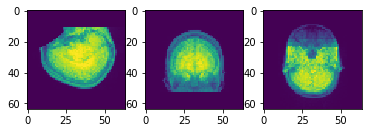

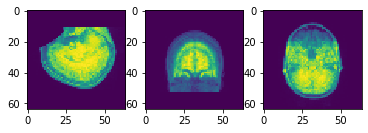

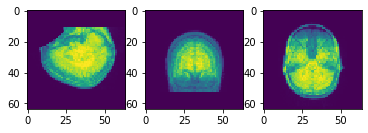

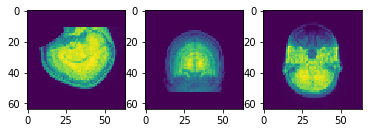

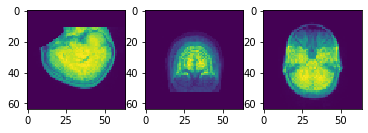

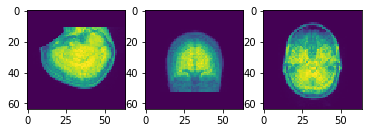

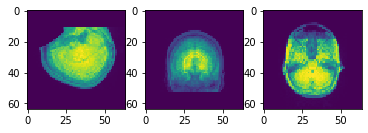

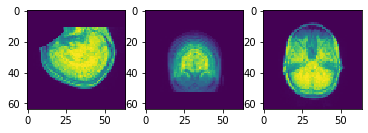

[INFO] Given volume is defaced with confidence of: 0.6462911367416382


In [18]:
import sys
# sys.path.append('..')
from helpers.utils import load_vol
# from defacing.inference import inferer

_inferer = inferer()
path = '../sample_vols/defaced/example2.nii.gz'
vol, _, _ = load_vol(path)
label, conf = _inferer.infer(vol)
